# CV3 ice contamination
We investigate the case of ice contamination during ISIM CV3 testing based on MRS data. The dataset used is that of the OSIM sapphire diffuser measurements, used for the MRS sky flat.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# import modules
import funcs
import mrsobs

import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'distortionMaps/'
lvl2path  = workDir+'CV3_data/LVL2/'

In [3]:
# load MRS detector images (BKG frames available only in SHORT band)
img_BKG_1A = fits.open(lvl2path+'MIRM0261MRI-BKG-5348142124_1_495_SE_2015-12-14T14h34m25_LVL2.fits')[0].data[0,:,:]

img_SCI_1A = fits.open(lvl2path+'MIRM0261MRI-950-5348144543_1_495_SE_2015-12-14T14h59m25_LVL2.fits')[0].data[0,:,:]
img_SCI_1B = fits.open(lvl2path+'MIRM0261MRI-900-5348143808_1_495_SE_2015-12-14T14h49m45_LVL2.fits')[0].data[0,:,:]
img_SCI_1C = fits.open(lvl2path+'MIRM0261MRI-850-5348143032_1_495_SE_2015-12-14T14h41m45_LVL2.fits')[0].data[0,:,:]

CV3_intcal_source_sci = {}
for band in ['1A','1B','1C','2A','2B','2C']:
    CV3_intcal_source_sci[band] = mrsobs.MIRI_internal_calibration_source(lvl2path,band,campaign='CV3')

# load MRS distortion information
lambdaMap,xpos = {},{}
for band in ['1A','1B','1C','2A','2B','2C']:
    d2cMaps = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    lambdaMap[band] = d2cMaps['lambdaMap']
    ypos,xpos[band] = funcs.detpixel_trace(band,d2cMaps,sliceID=10,alpha_pos=0.)
    
# the alpha distortion information from the DISTORTION CDP v7B.05.00 is inaccurate and yields jumps in the plotted internal calibration source spectrum
# We bypass this issue by using the PSF peak position of a CV2 point source observation
pointing = 'CV3_Q0'
for band in ['1A','1B','1C']:
    d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    key = pointing.split('_')[1]
    CV3_pointings_dict = mrsobs.CV_800K_BB_MRS_OPT_02_obs(lvl2path,band,campaign='CV3')
    point_source_sci,point_source_bkg = fits.open(lvl2path+CV3_pointings_dict[pointing][1])[0].data[0,:,:],fits.open(lvl2path+CV3_pointings_dict[pointing][3])[0].data[0,:,:]
    point_source_bkgsubtr = point_source_sci-point_source_bkg
    
    # optimize the detector pixel trace
    ypos,xpos[band] = funcs.detpixel_trace_compactsource(point_source_bkgsubtr,band,d2cMaps,offset_slice=0,verbose=False)

<IPython.core.display.Javascript object>


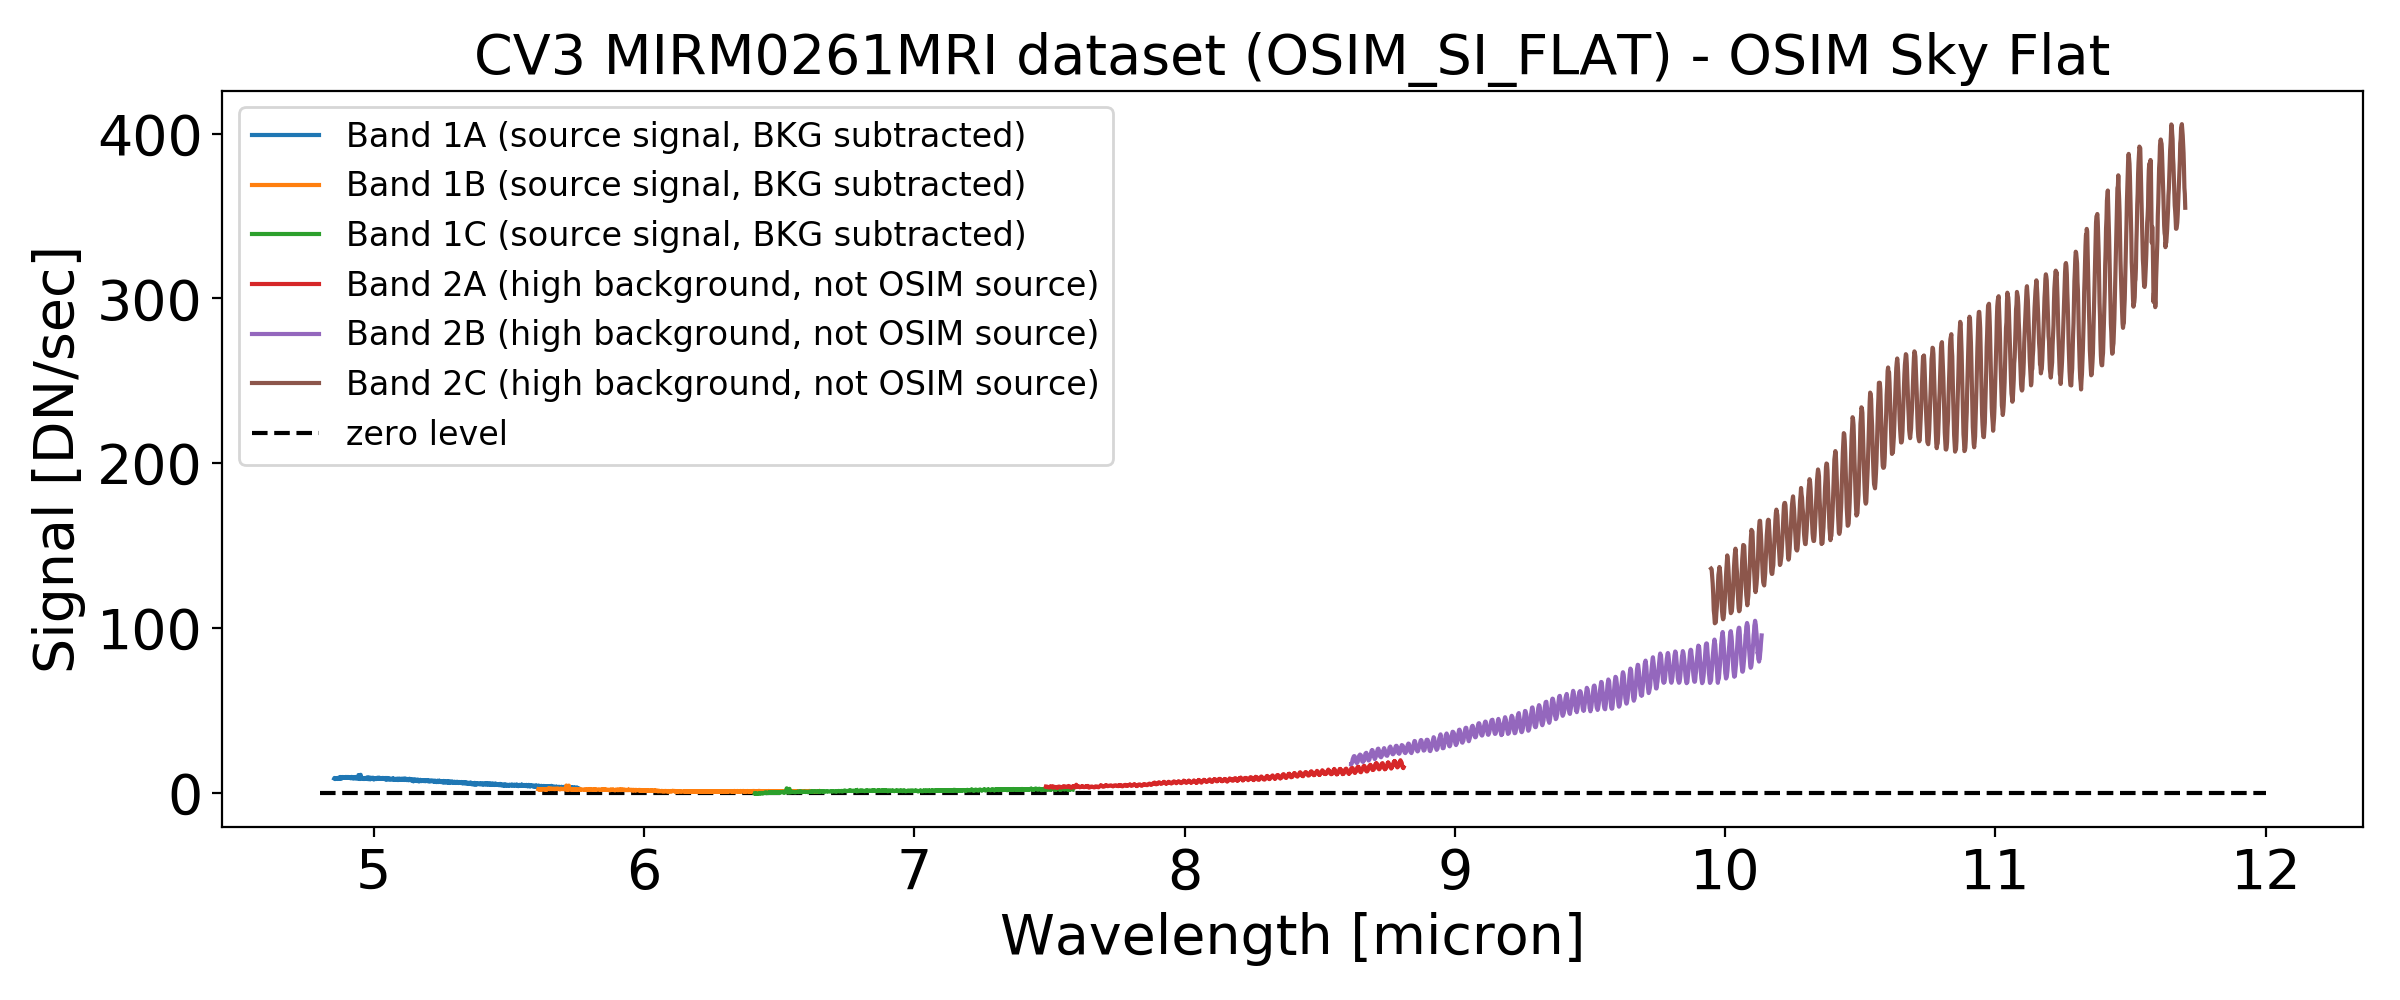

<IPython.core.display.Javascript object>


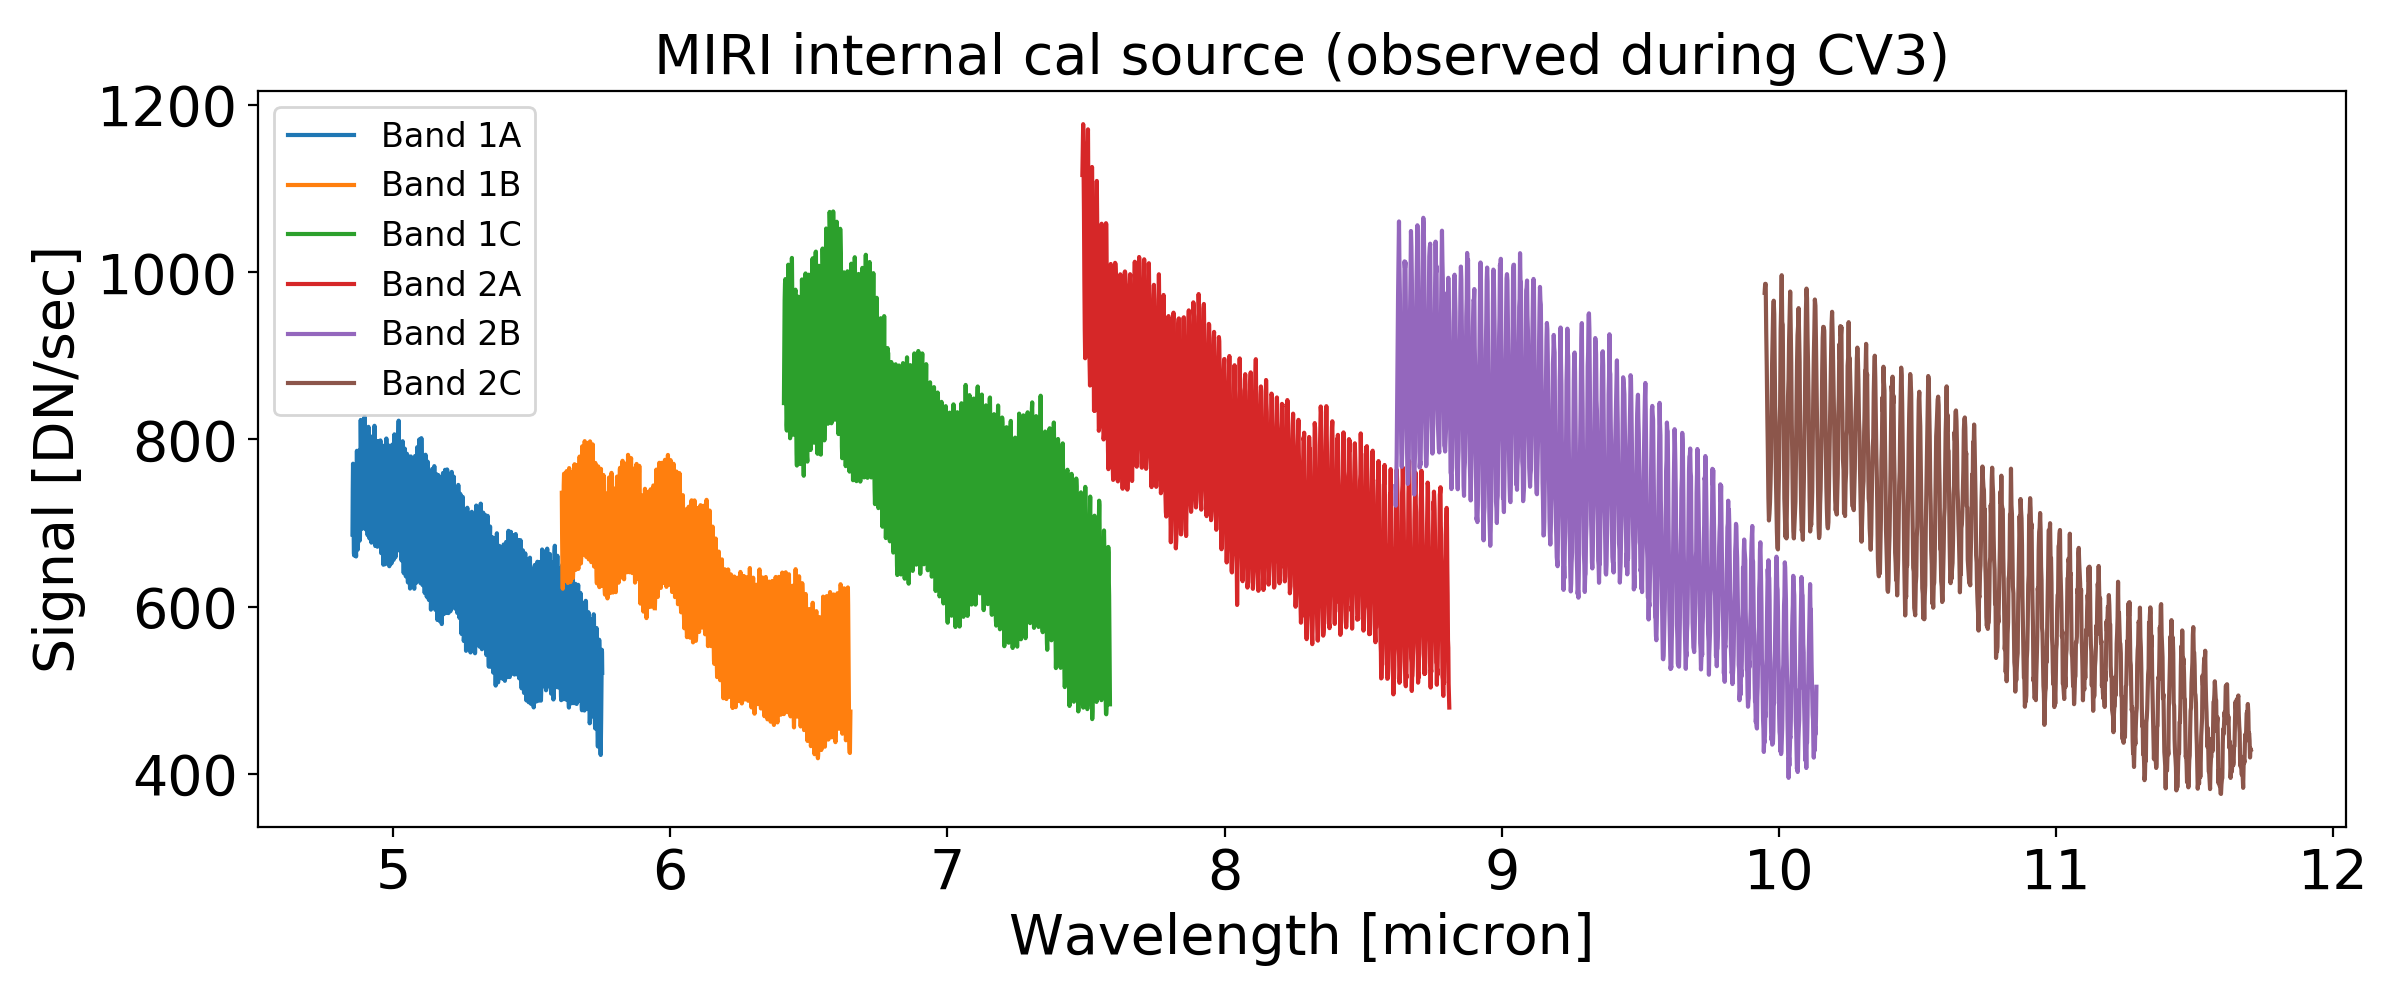

<IPython.core.display.Javascript object>


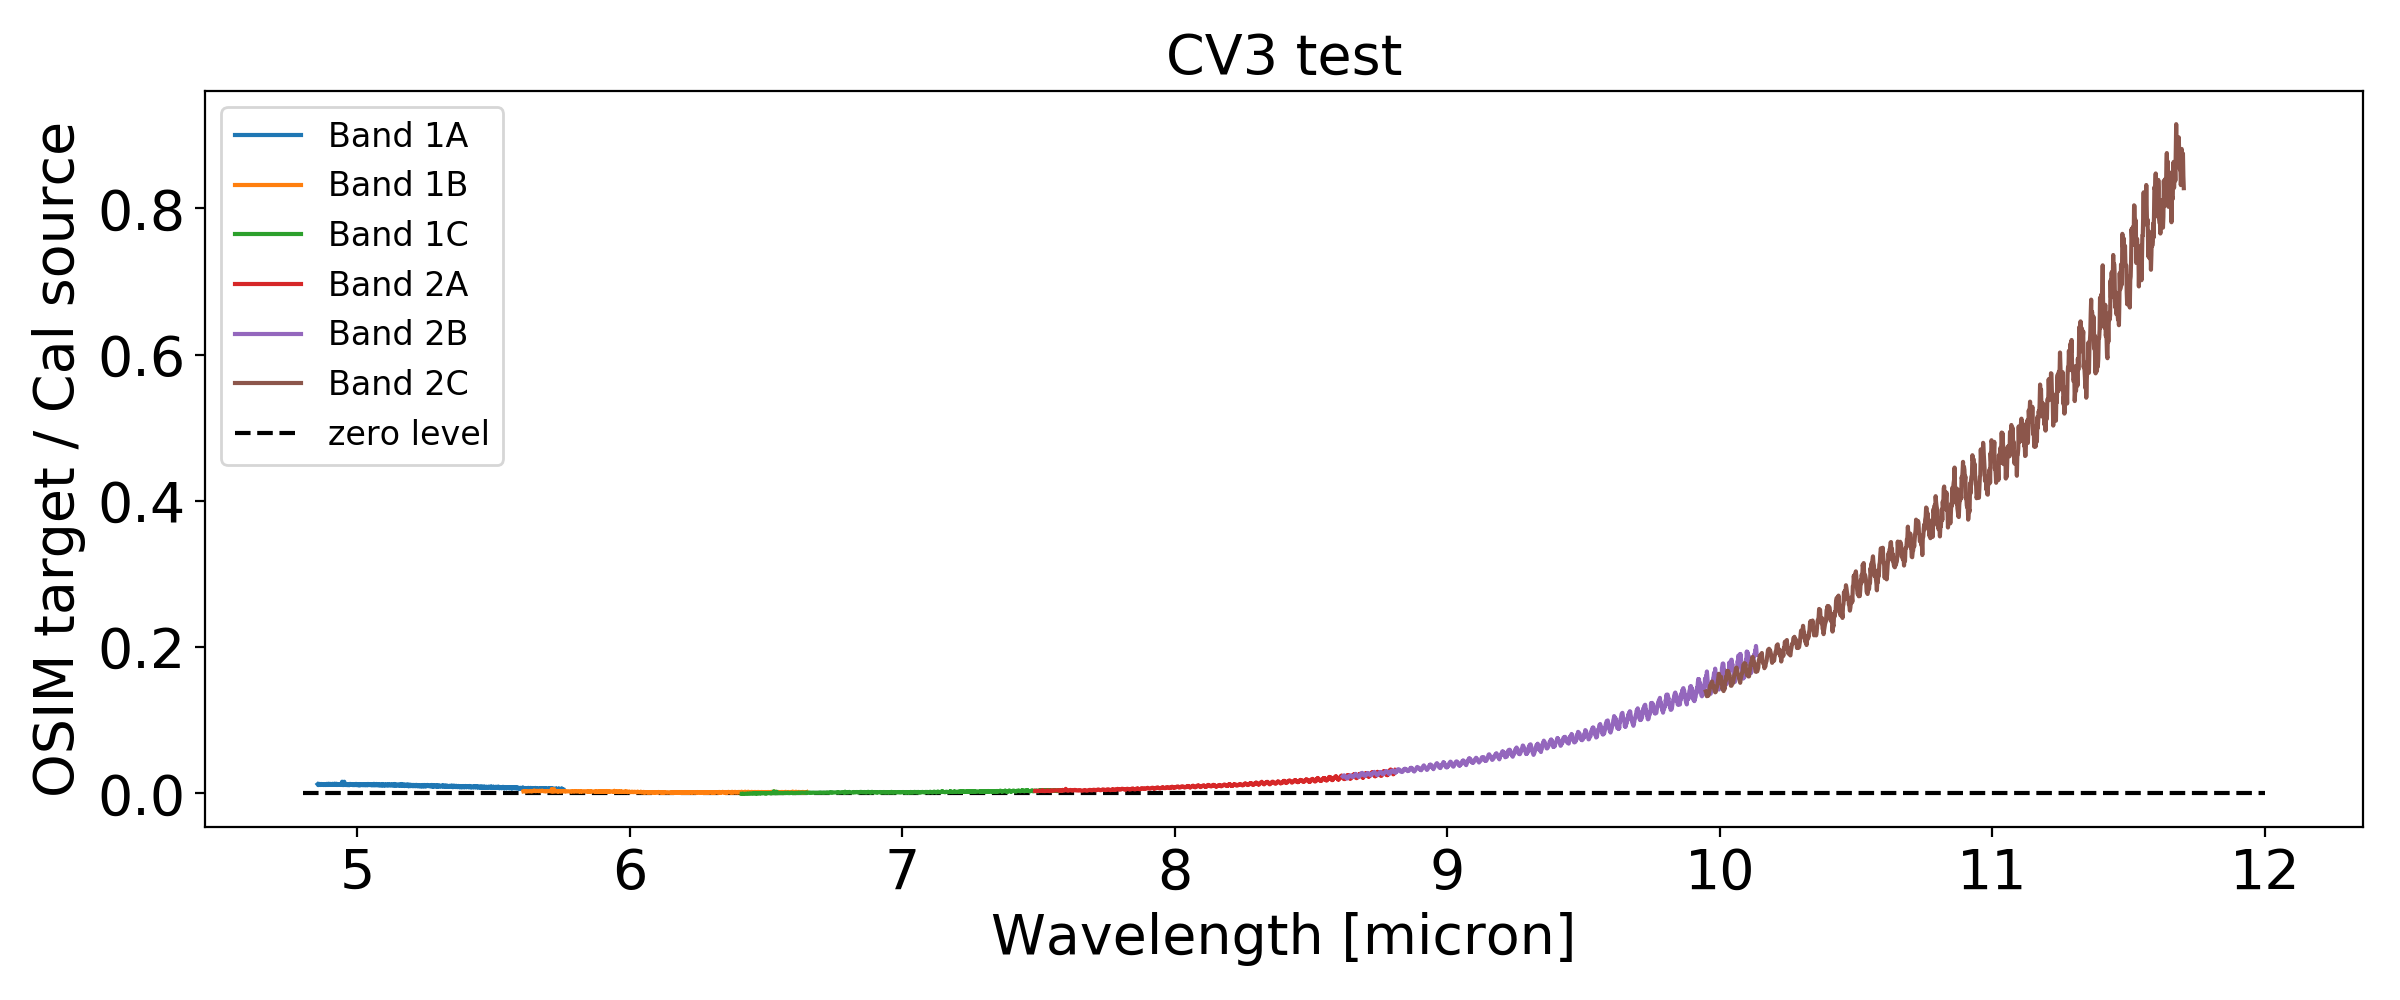

In [4]:
# plot pixel trace
plt.figure(figsize=(12,5))
plt.title('CV3 MIRM0261MRI dataset (OSIM_SI_FLAT) - OSIM Sky Flat')
plt.plot(lambdaMap['1A'][ypos,xpos['1A']][5:-5],img_SCI_1A[ypos,xpos['1A']][5:-5],label='Band 1A (source signal, BKG subtracted)')
plt.plot(lambdaMap['1B'][ypos,xpos['1B']][5:-5],img_SCI_1B[ypos,xpos['1B']][5:-5],label='Band 1B (source signal, BKG subtracted)')
plt.plot(lambdaMap['1C'][ypos,xpos['1C']][5:-5],img_SCI_1C[ypos,xpos['1C']][5:-5],label='Band 1C (source signal, BKG subtracted)')

plt.plot(lambdaMap['2A'][ypos,xpos['2A']][5:-5],img_SCI_1A[ypos,xpos['2A']][5:-5],label='Band 2A (high background, not OSIM source)')
plt.plot(lambdaMap['2B'][ypos,xpos['2B']][5:-5],img_SCI_1B[ypos,xpos['2B']][5:-5],label='Band 2B (high background, not OSIM source)')
plt.plot(lambdaMap['2C'][ypos,xpos['2C']][5:-5],img_SCI_1C[ypos,xpos['2C']][5:-5],label='Band 2C (high background, not OSIM source)')

plt.hlines(0,4.8,12,linestyle='dashed',label='zero level')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [DN/sec]')
plt.legend(loc='upper left',fontsize=12)
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.title('MIRI internal cal source (observed during CV3)')
for band in ['1A','1B','1C','2A','2B','2C']:
    plt.plot(lambdaMap[band][ypos,xpos[band]][5:-5],CV3_intcal_source_sci[band][ypos,xpos[band]][5:-5],label='Band {}'.format(band))
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [DN/sec]')
plt.legend(loc='upper left',fontsize=12)
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.title('CV3 test')
plt.plot(lambdaMap['1A'][ypos,xpos['1A']][5:-5],(img_SCI_1A/CV3_intcal_source_sci['1A'])[ypos,xpos['1A']][5:-5],label='Band 1A')
plt.plot(lambdaMap['1B'][ypos,xpos['1B']][5:-5],(img_SCI_1B/CV3_intcal_source_sci['1B'])[ypos,xpos['1B']][5:-5],label='Band 1B')
plt.plot(lambdaMap['1C'][ypos,xpos['1C']][5:-5],(img_SCI_1C/CV3_intcal_source_sci['1C'])[ypos,xpos['1C']][5:-5],label='Band 1C')

plt.plot(lambdaMap['2A'][ypos,xpos['2A']][5:-5],(img_SCI_1A/CV3_intcal_source_sci['2A'])[ypos,xpos['2A']][5:-5],label='Band 2A')
plt.plot(lambdaMap['2B'][ypos,xpos['2B']][5:-5],(img_SCI_1B/CV3_intcal_source_sci['2B'])[ypos,xpos['2B']][5:-5],label='Band 2B')
plt.plot(lambdaMap['2C'][ypos,xpos['2C']][5:-5],(img_SCI_1C/CV3_intcal_source_sci['2C'])[ypos,xpos['2C']][5:-5],label='Band 2C')

plt.hlines(0,4.8,12,linestyle='dashed',label='zero level')
plt.xlabel('Wavelength [micron]')
plt.ylabel('OSIM target / Cal source')
plt.legend(loc='upper left',fontsize=12)
plt.tight_layout()

<IPython.core.display.Javascript object>


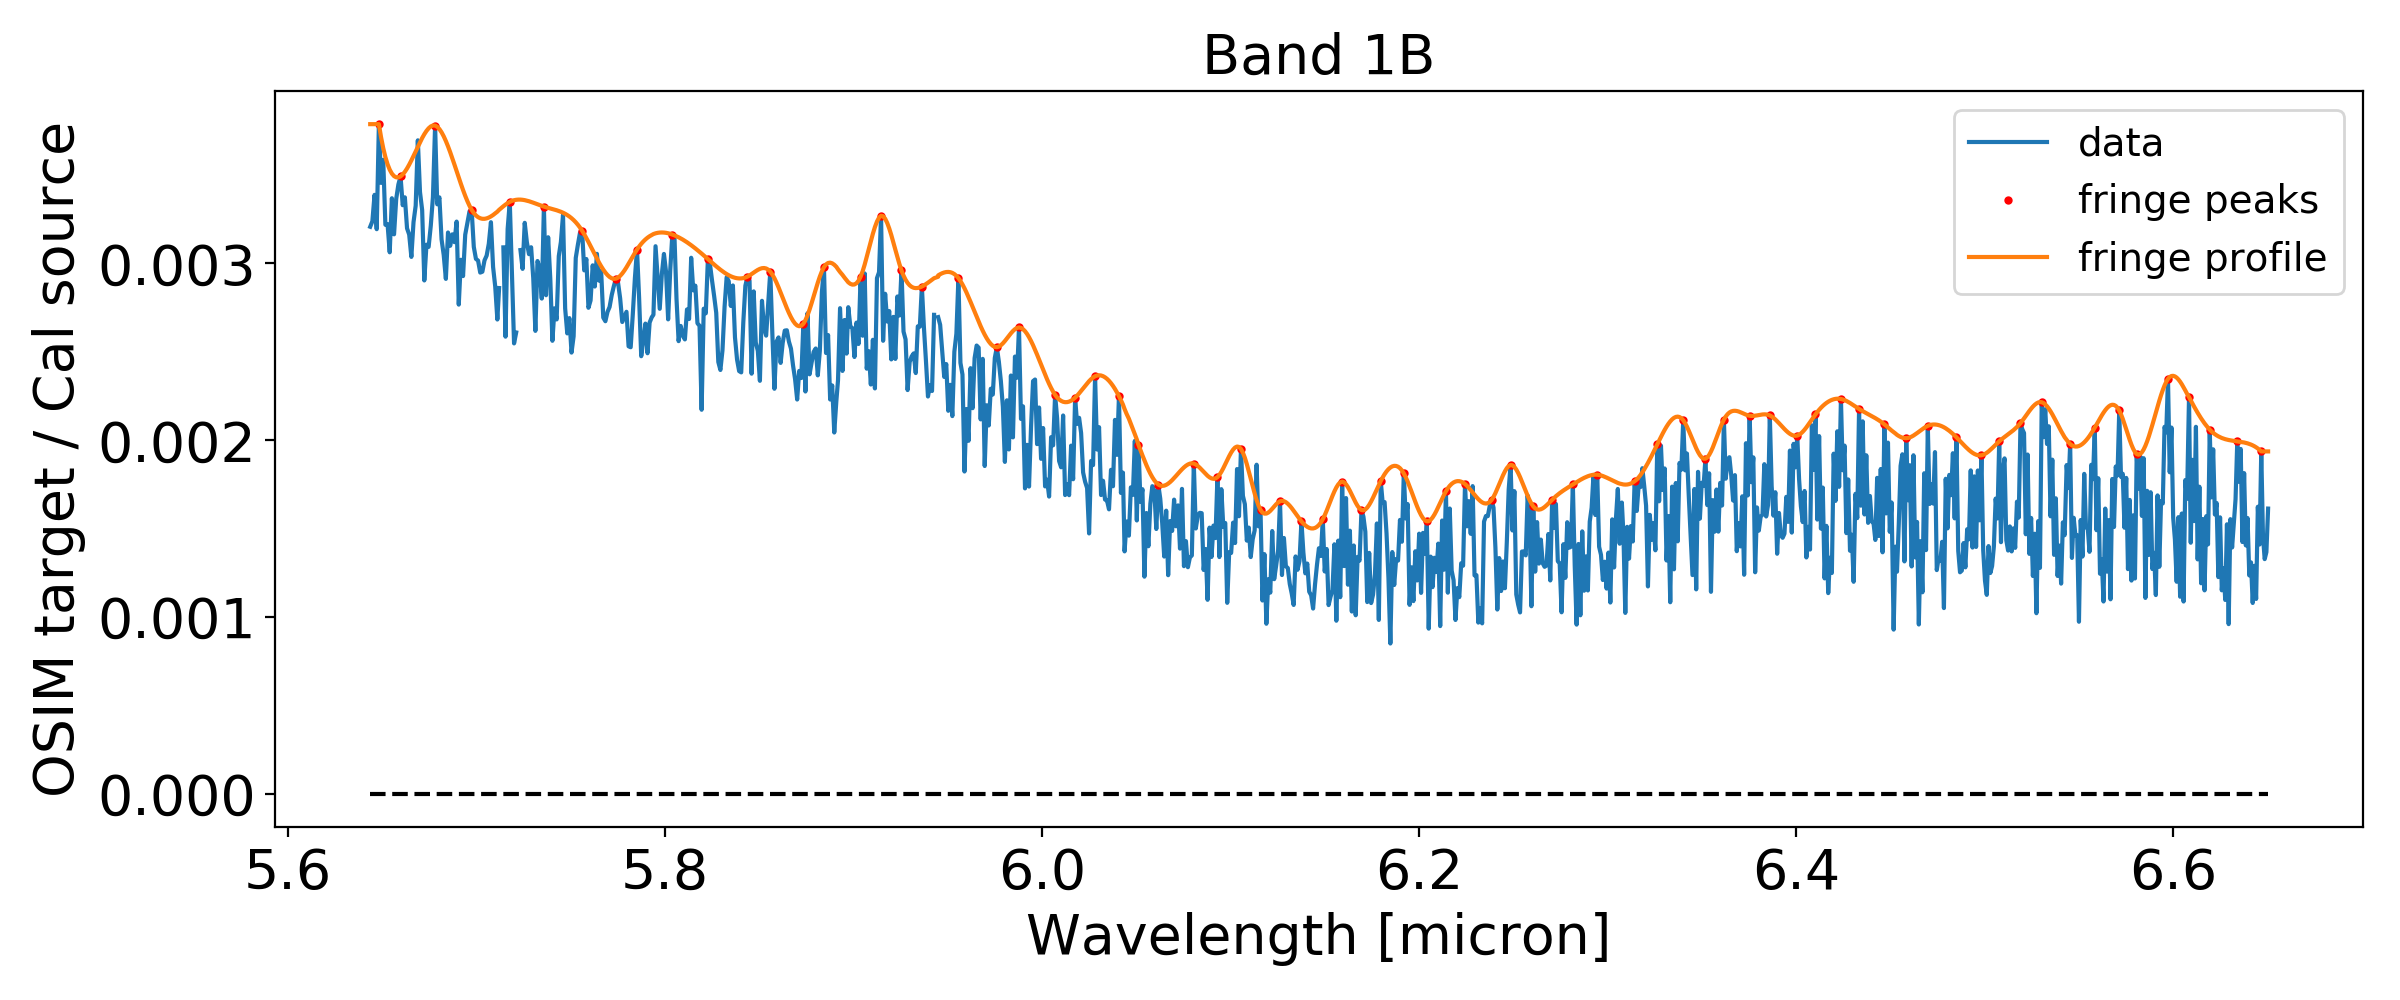

<IPython.core.display.Javascript object>


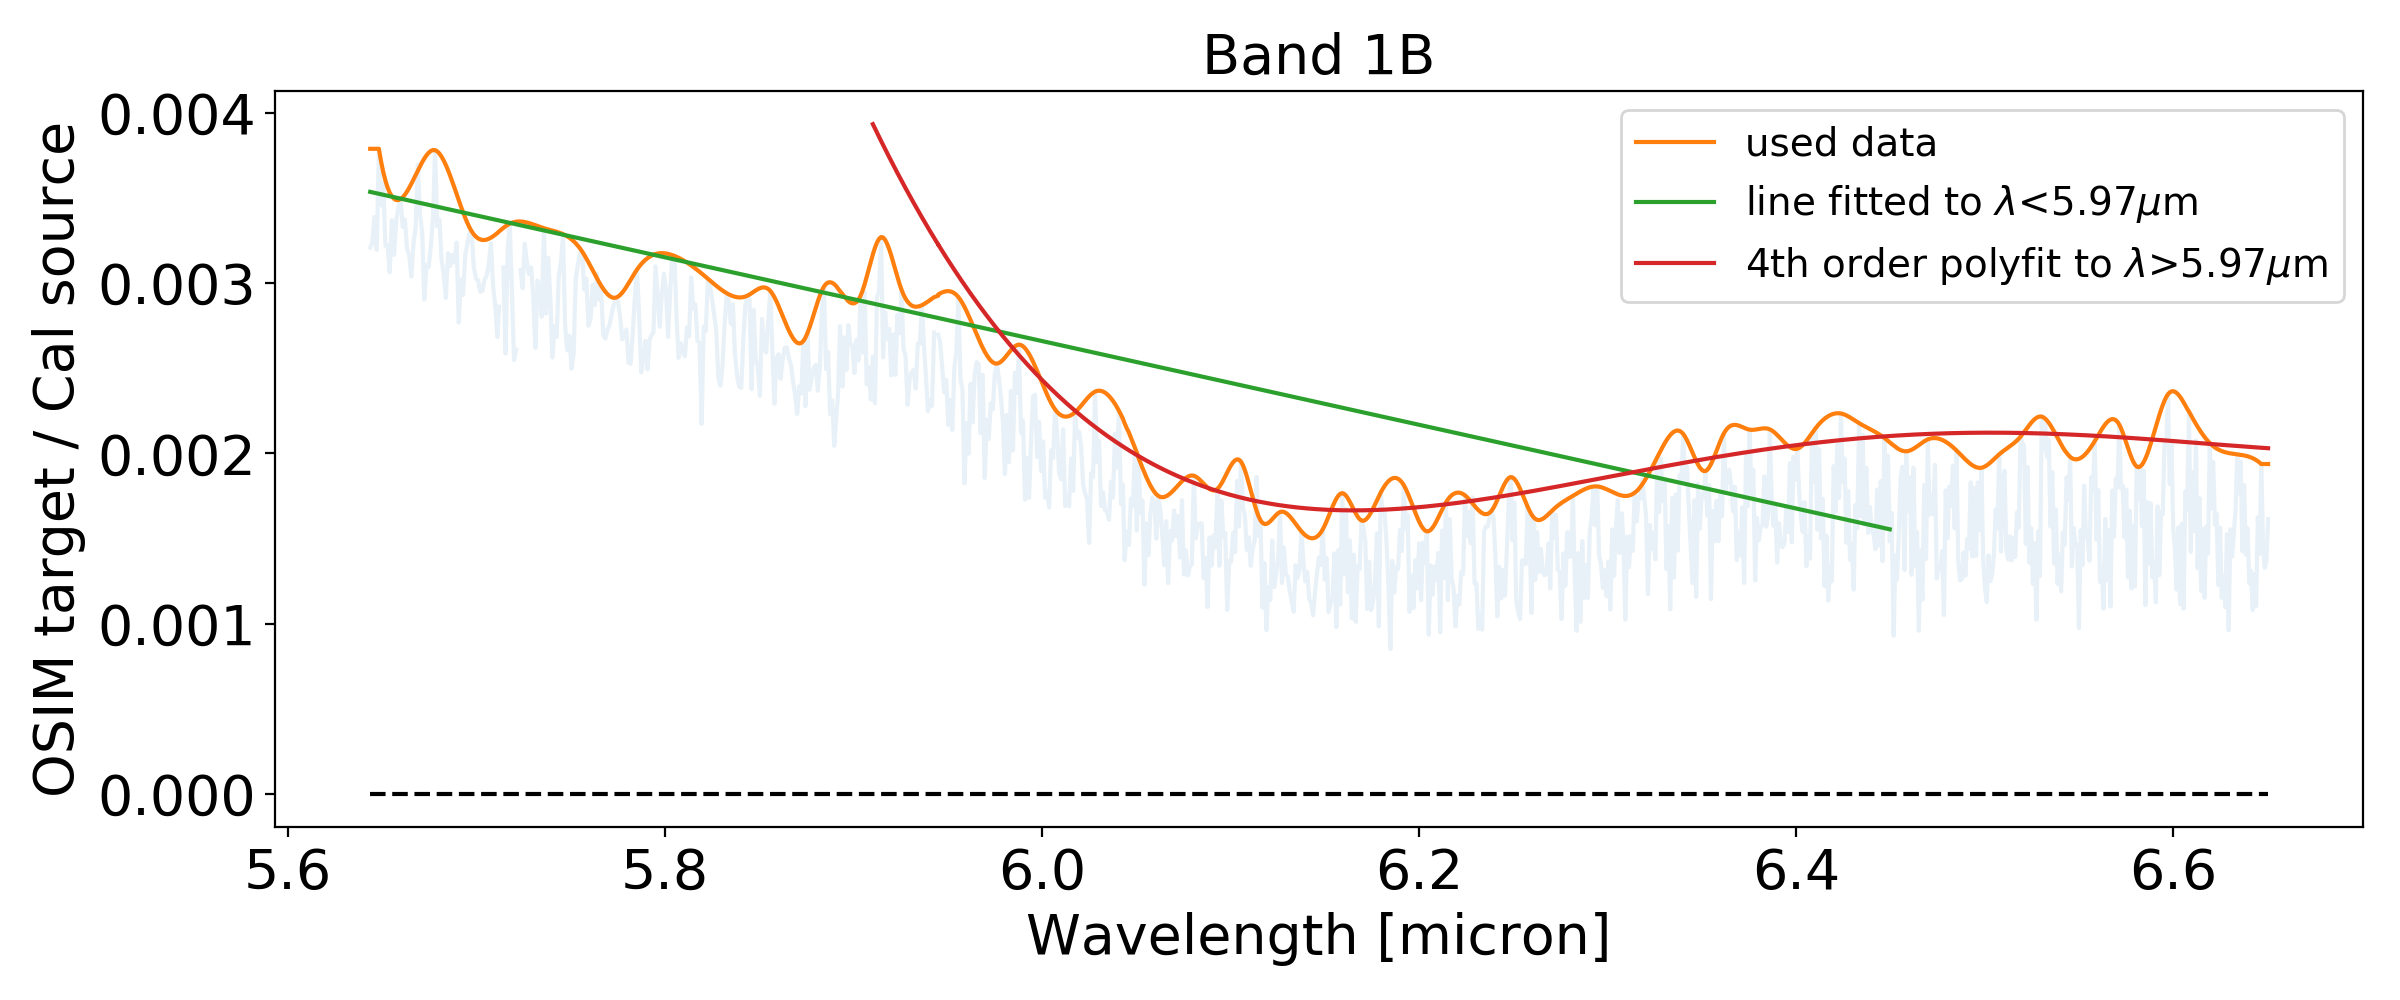

<IPython.core.display.Javascript object>


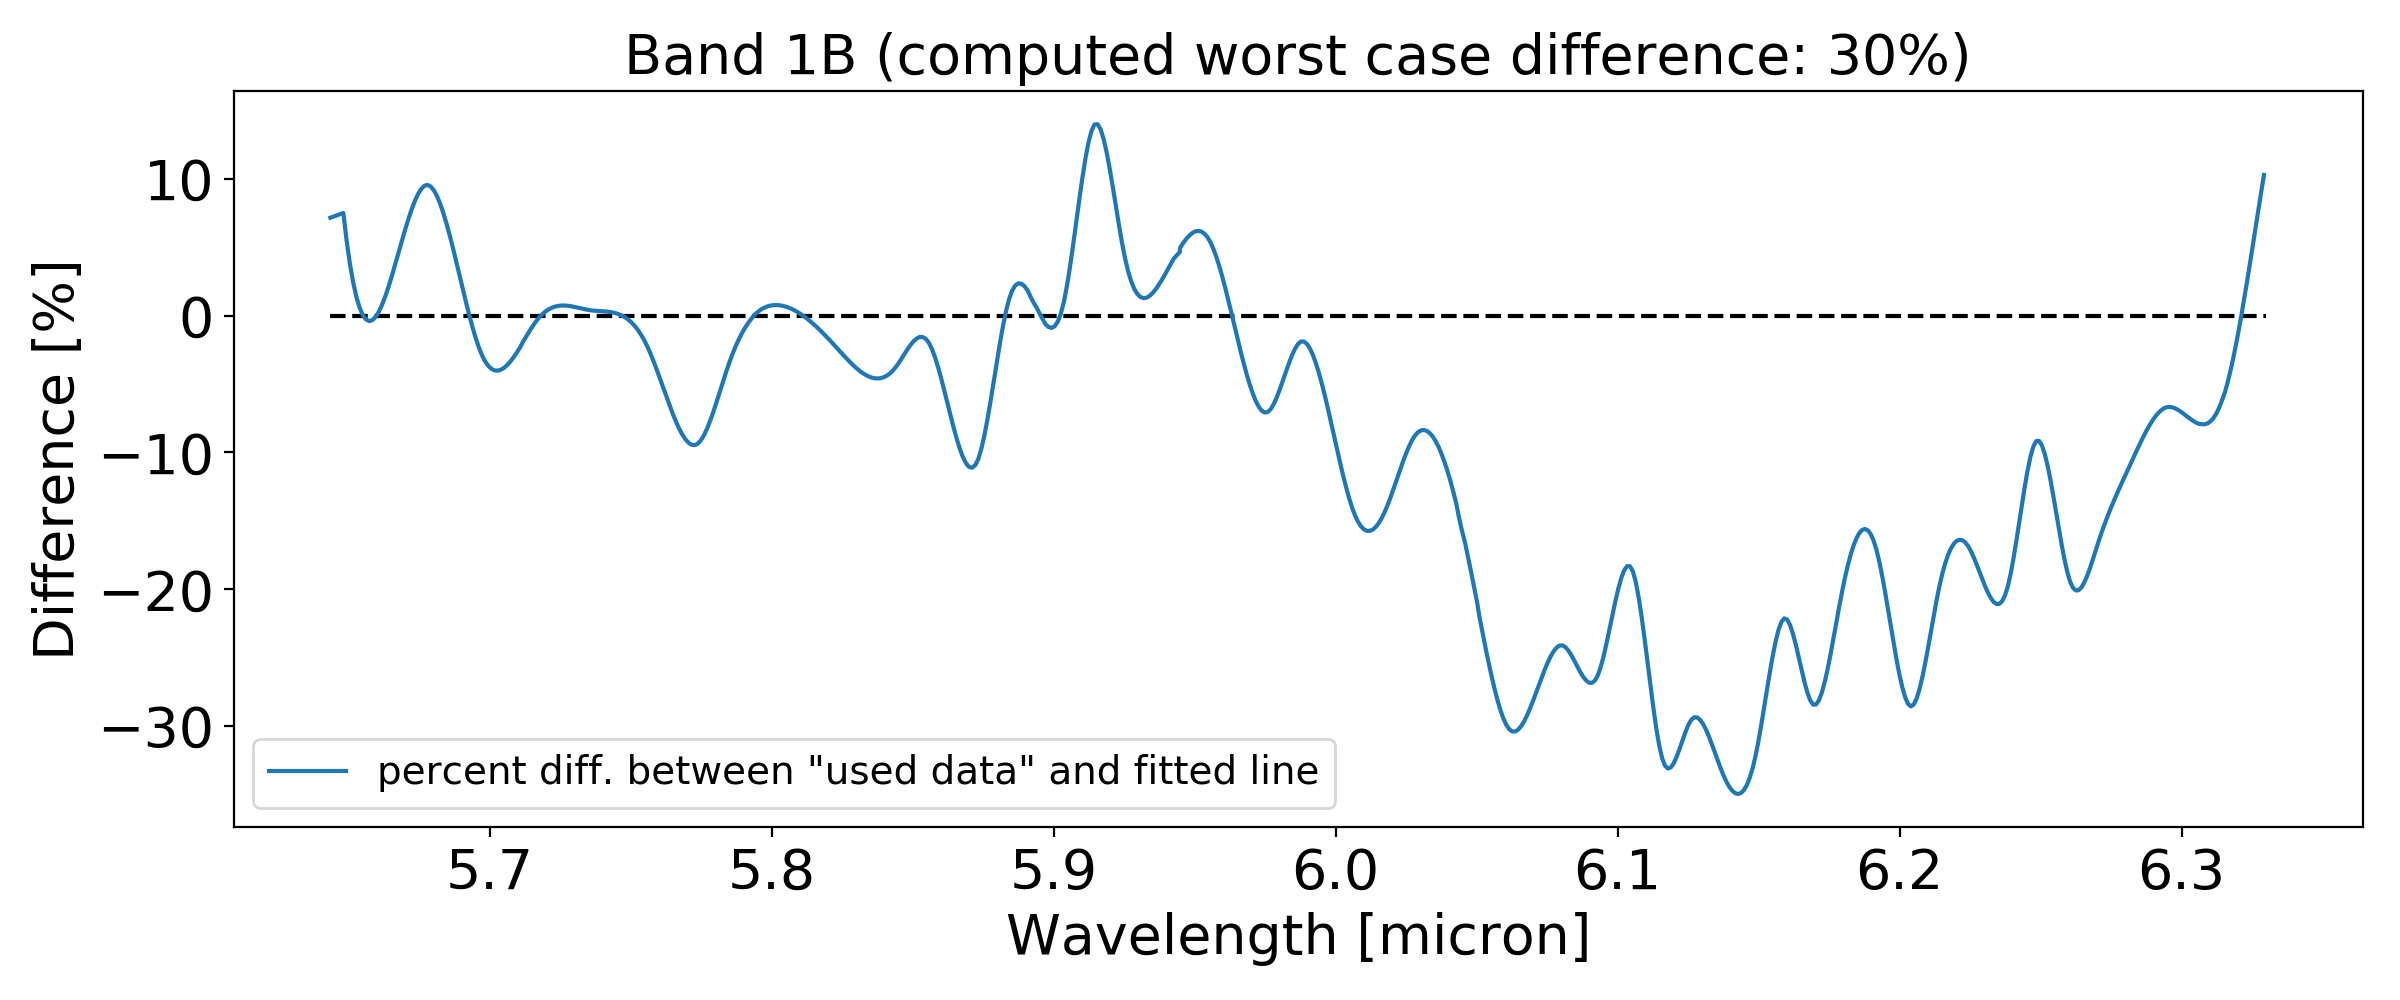

In [6]:
# Examine the OSIM sky flat data in band 1B (wavelength range 5.62-6.73 micron)
lambdas = lambdaMap['1B'][ypos,xpos['1B']][35:-5]
data = (img_SCI_1B/CV3_intcal_source_sci['1B'])[ypos,xpos['1B']][35:-5]
data[data>0.005] = np.nan
data_noNaN,peaks,data_profile = funcs.norm_fringe(data,thres=0,min_dist=9,k=3,ext=3)

# plot starter analysis
plt.figure(figsize=(12,5))
plt.title('Band 1B')
plt.plot(lambdas,data,label='data')
plt.plot(lambdas[peaks],data_noNaN[peaks],'ro',markersize=2,label='fringe peaks')
plt.plot(lambdas,data_profile,label='fringe profile')
plt.hlines(0,lambdas.min(),lambdas.max(),linestyle='dashed')
plt.xlabel('Wavelength [micron]')
plt.ylabel('OSIM target / Cal source')
plt.legend(loc='upper right')
plt.tight_layout()

# Investigate regions of interest
sel = (lambdas <5.97)
popt1     = np.polyfit(lambdas[sel],data_profile[sel],1)
poly1     = np.poly1d(popt1)

sel = (lambdas > 5.972)
popt2     = np.polyfit(lambdas[sel],data_profile[sel],4)
poly2     = np.poly1d(popt2)

# plot resulting fits and residuals
plt.figure(figsize=(12,5))
plt.title('Band 1B')
plt.plot(lambdas,data,alpha=0.1)
plt.plot(lambdas,data_profile,label='used data')
plt.plot(lambdas[lambdas<6.45],poly1(lambdas[lambdas<6.45]),label=r'line fitted to $\lambda$<5.97$\mu$m')
plt.plot(lambdas[(lambdas > 5.91)],poly2(lambdas[(lambdas > 5.91)]),label=r'4th order polyfit to $\lambda$>5.97$\mu$m')
plt.hlines(0,lambdas.min(),lambdas.max(),linestyle='dashed')
plt.xlabel('Wavelength [micron]')
plt.ylabel('OSIM target / Cal source')
plt.legend(loc='upper right')
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.title('Band 1B (computed worst case difference: 30%)')
plt.plot(lambdas[lambdas<6.33],((data_profile-poly1(lambdas))/poly1(lambdas))[lambdas<6.33]*100.,label='percent diff. between "used data" and fitted line')
plt.hlines(0,lambdas.min(),6.33,linestyle='dashed')
plt.xlabel('Wavelength [micron]')
plt.ylabel(r'Difference [%]')
plt.legend(loc='lower left')
plt.tight_layout()

<IPython.core.display.Javascript object>


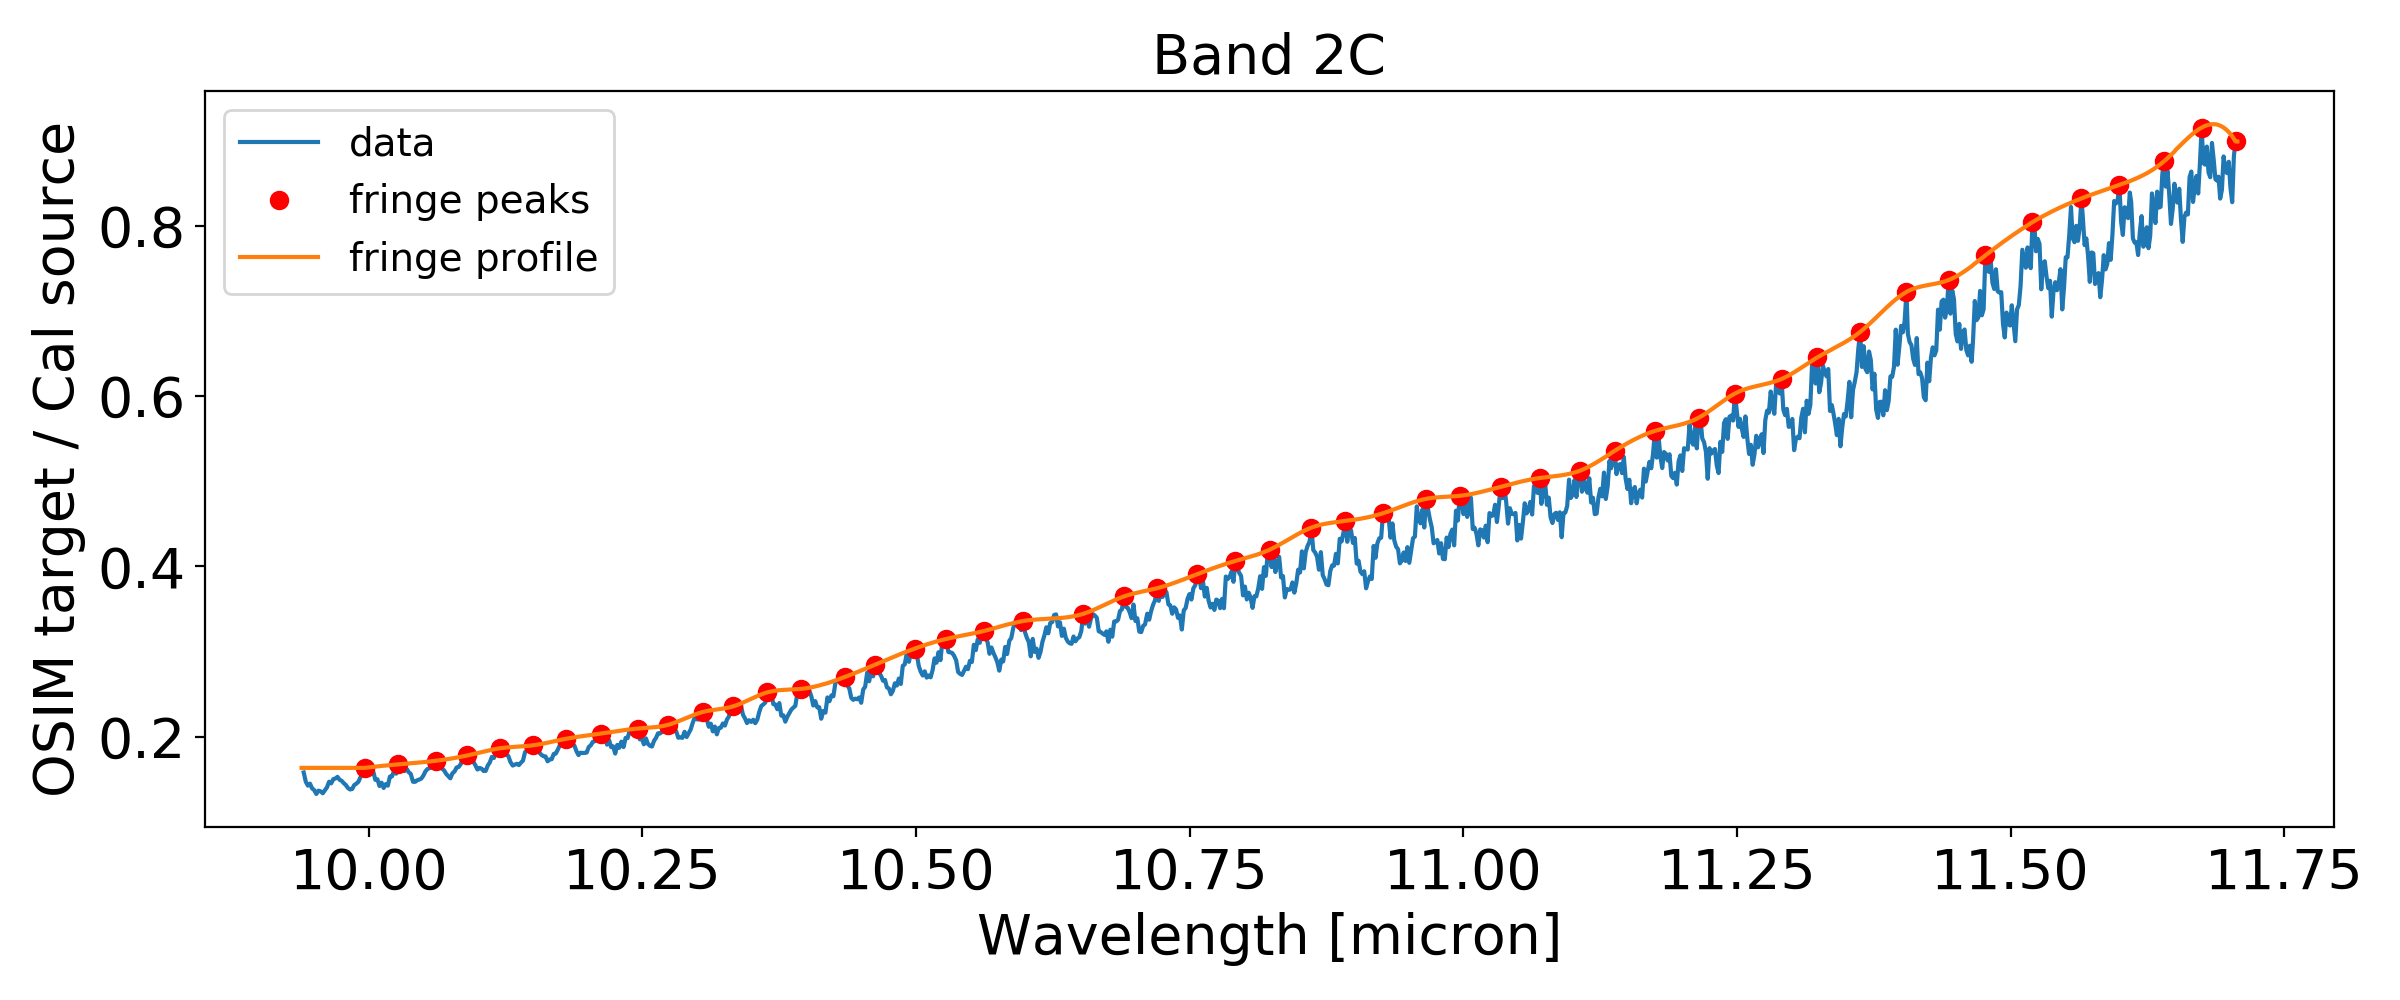

<IPython.core.display.Javascript object>


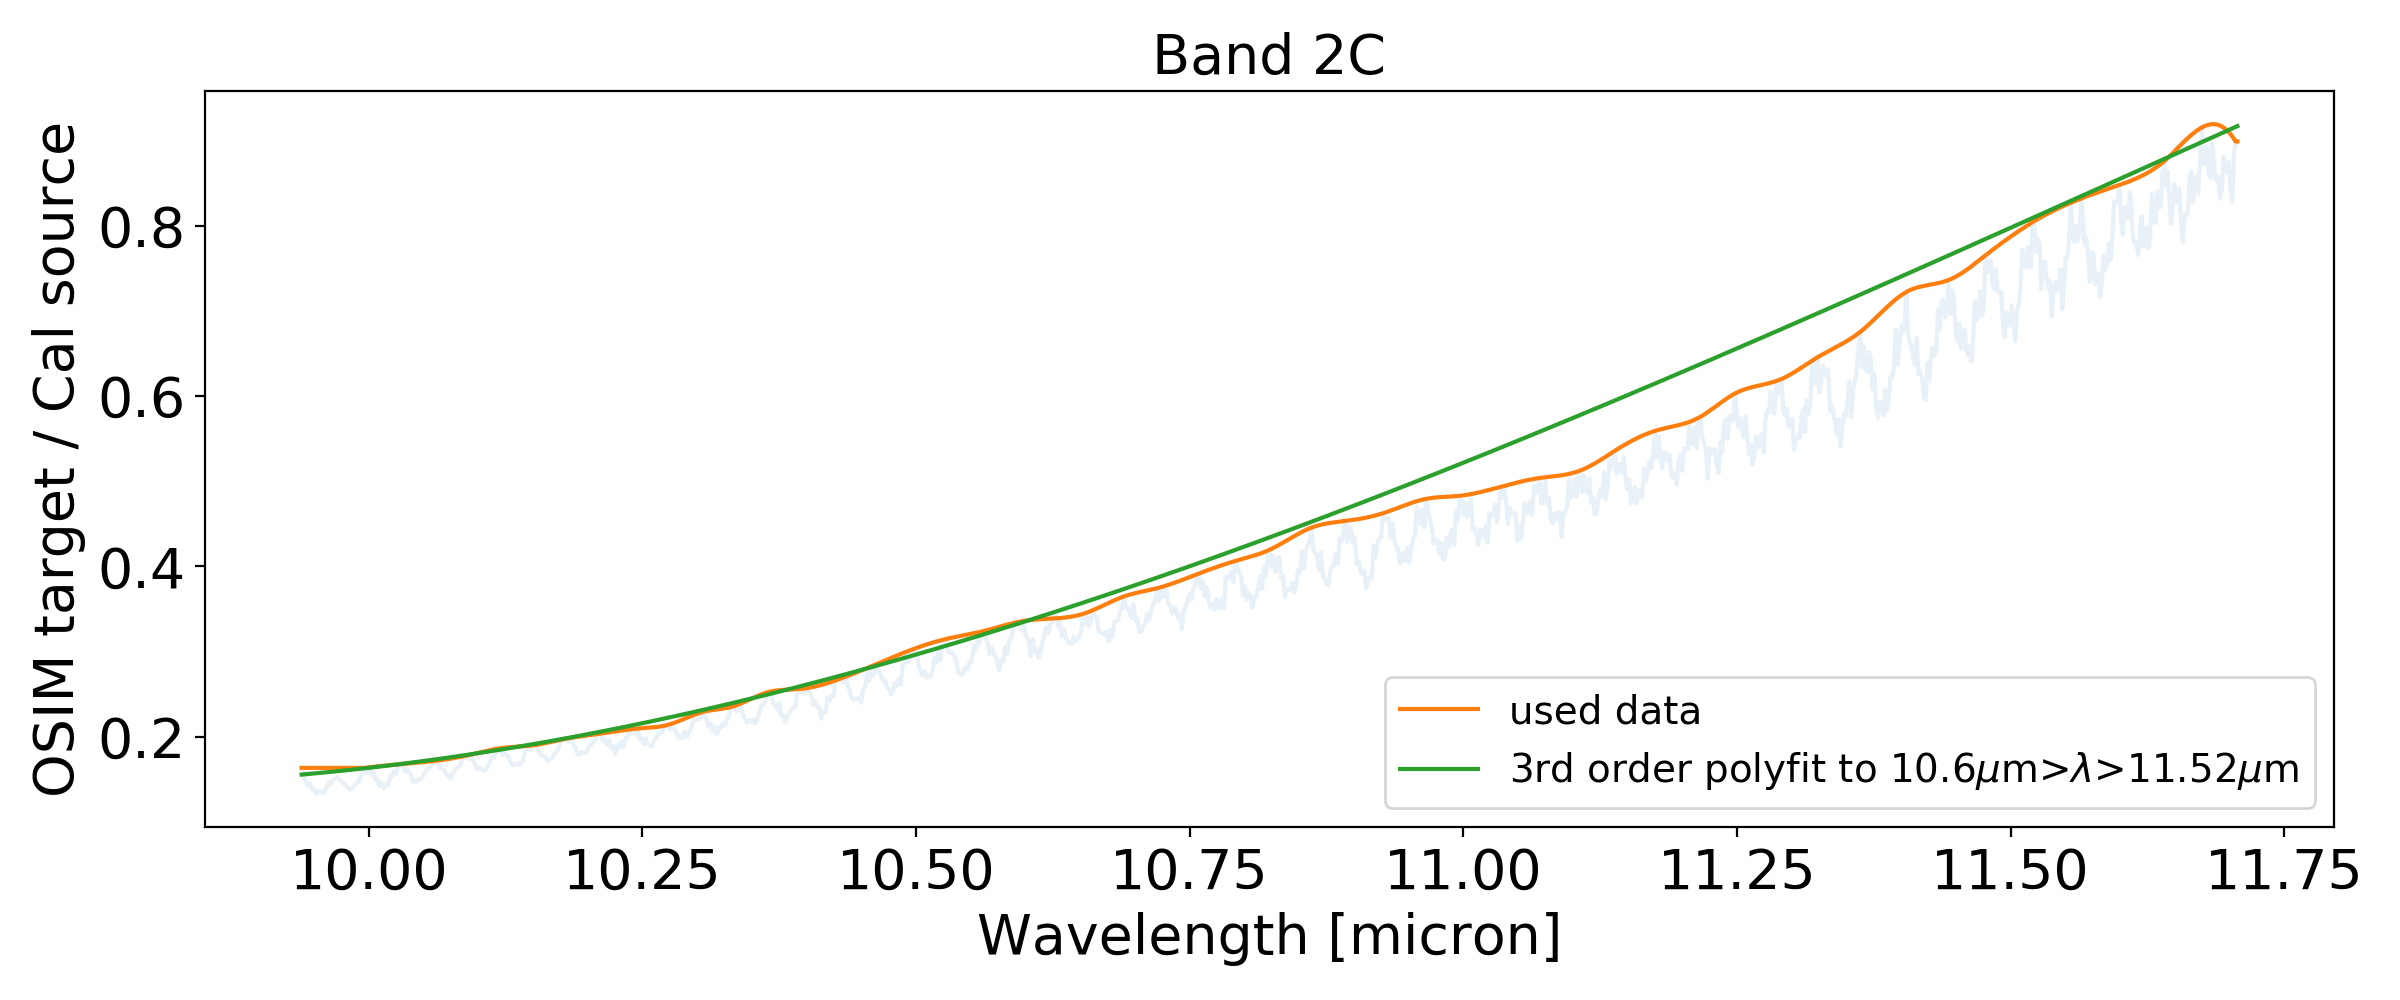

<IPython.core.display.Javascript object>


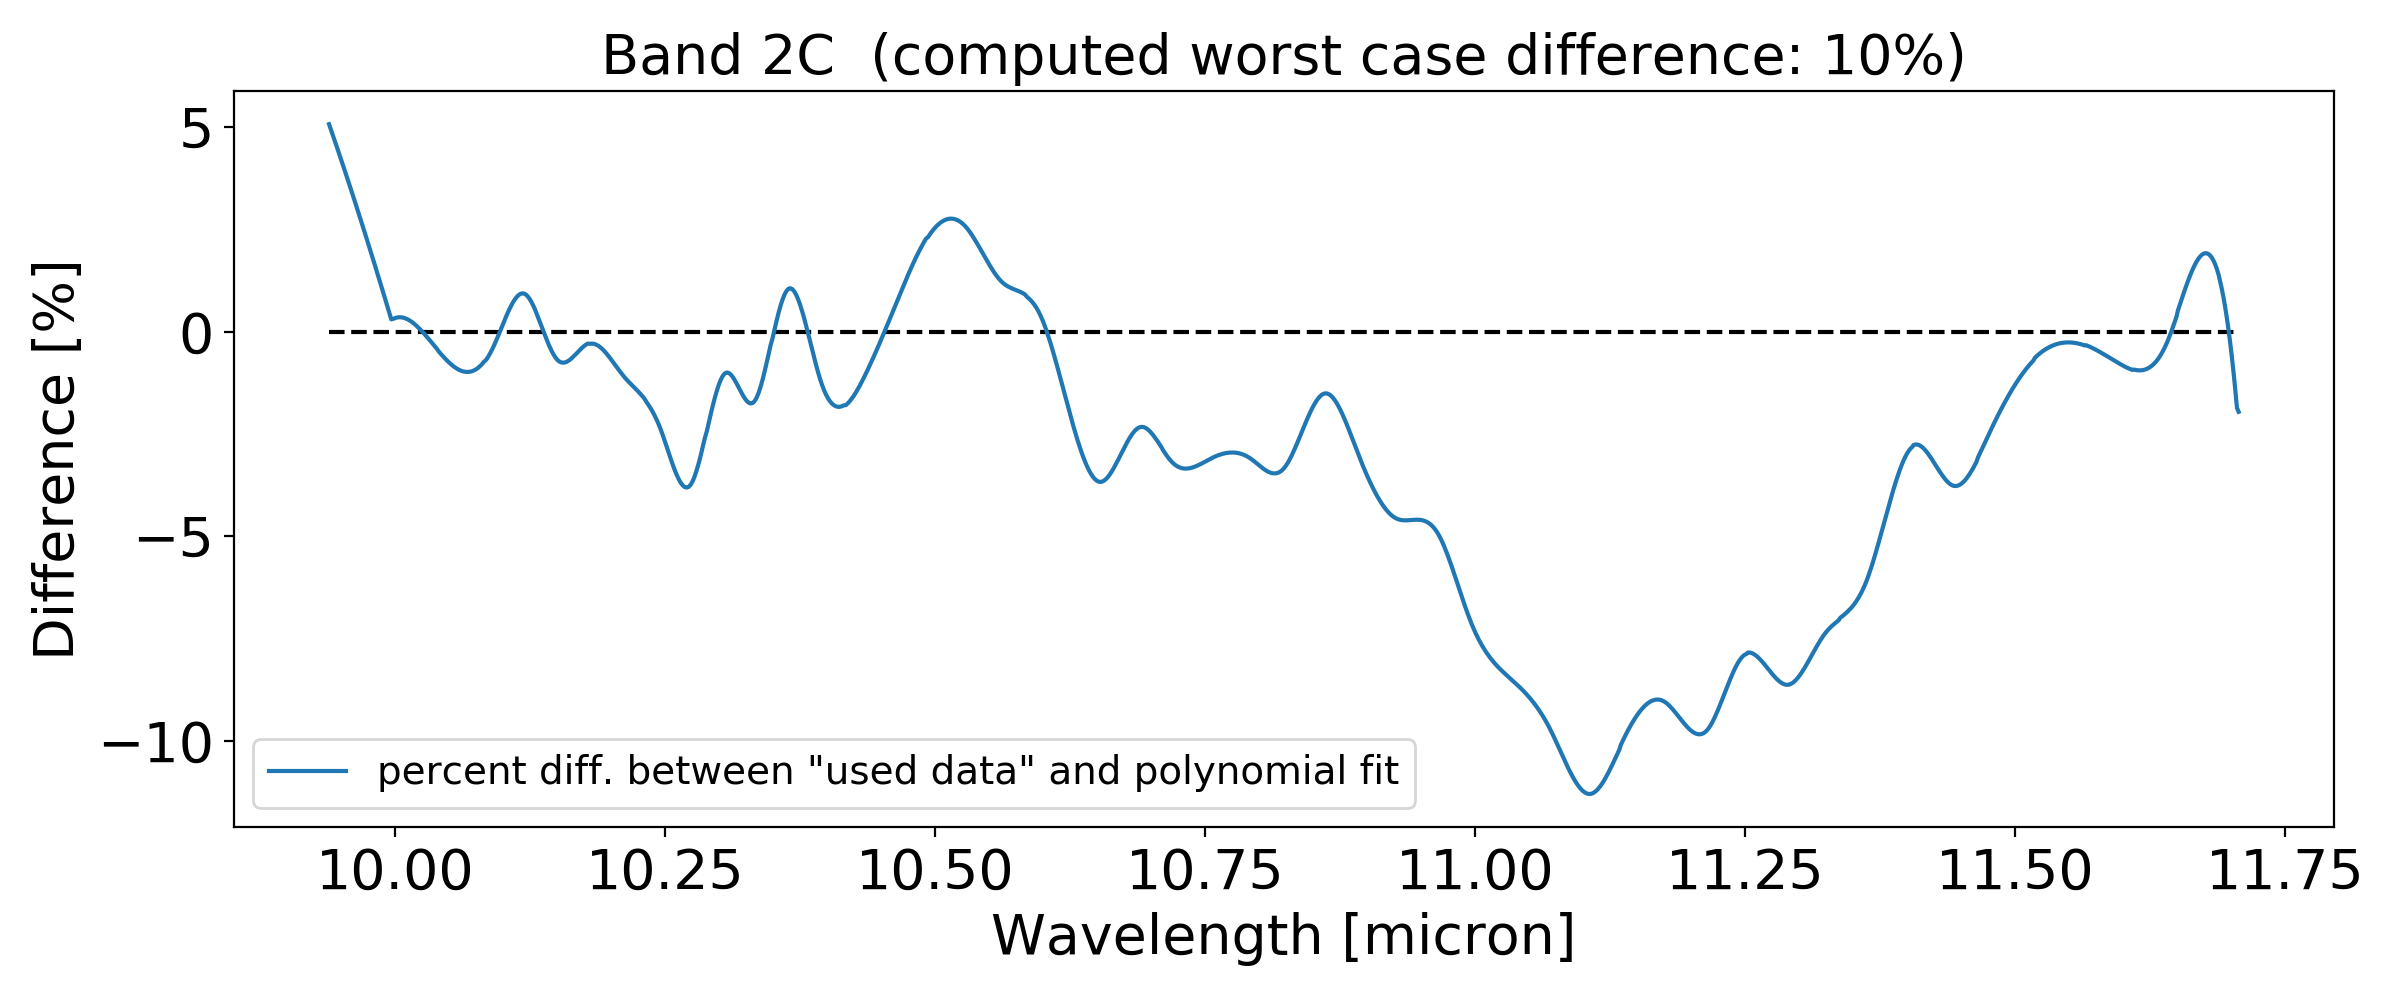

In [7]:
# Examine the OSIM sky flat data in band 2C (wavelength range 9.94-11.87 micron)
lambdas = lambdaMap['2C'][ypos,xpos['2C']][:-2]
data = (img_SCI_1C/CV3_intcal_source_sci['2C'])[ypos,xpos['2C']][:-2]
data_noNaN,peaks,data_profile = funcs.norm_fringe(data,thres=0,min_dist=14,k=3,ext=3)

# plot starter analysis
plt.figure(figsize=(12,5))
plt.title('Band 2C')
plt.plot(lambdas,data,label='data')
plt.plot(lambdas[peaks],data_noNaN[peaks],'ro',label='fringe peaks')
plt.plot(lambdas,data_profile,label='fringe profile')
plt.xlabel('Wavelength [micron]')
plt.ylabel('OSIM target / Cal source')
plt.legend(loc='upper left')
plt.tight_layout()

# Investigate region of interest
sel = (lambdas > 10.6) & (lambdas<11.52)
popt1     = np.polyfit(lambdas[~sel],data_profile[~sel],3)
poly1     = np.poly1d(popt1)

# plot resulting fit and residuals
plt.figure(figsize=(12,5))
plt.title('Band 2C')
plt.plot(lambdas,data,alpha=0.1)
plt.plot(lambdas,data_profile,label='used data')
plt.plot(lambdas,poly1(lambdas),label=r'3rd order polyfit to 10.6$\mu$m>$\lambda$>11.52$\mu$m')
plt.xlabel('Wavelength [micron]')
plt.ylabel('OSIM target / Cal source')
plt.legend(loc='lower right')
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.title('Band 2C  (computed worst case difference: 10%)')
plt.plot(lambdas,((data_profile-poly1(lambdas))/poly1(lambdas))*100.,label='percent diff. between "used data" and polynomial fit')
plt.hlines(0,lambdas.min(),lambdas.max(),linestyle='dashed')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Difference [%]')
plt.legend(loc='lower left')
plt.tight_layout()

## Check some other bands for potential systematics

<IPython.core.display.Javascript object>


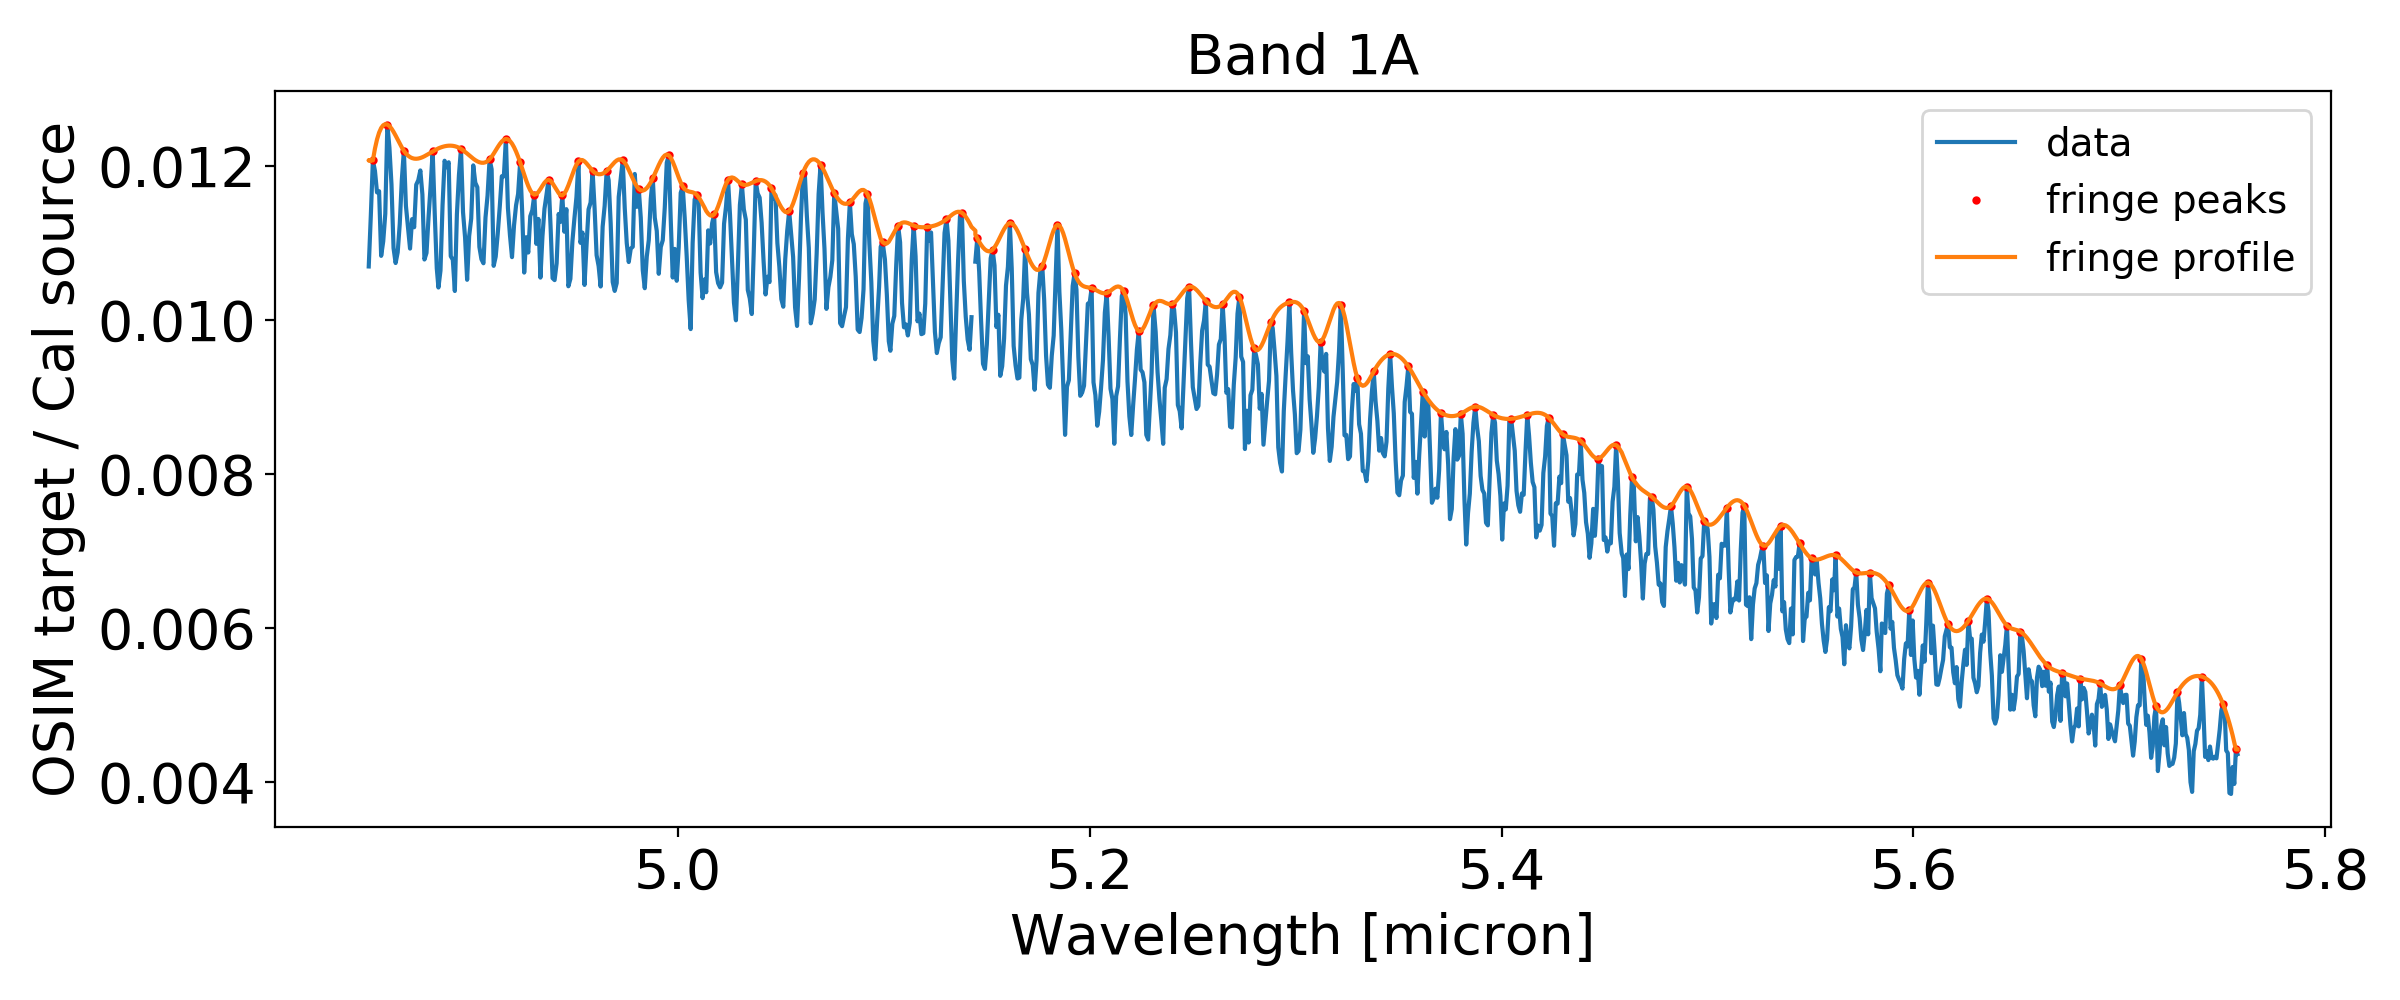

<IPython.core.display.Javascript object>


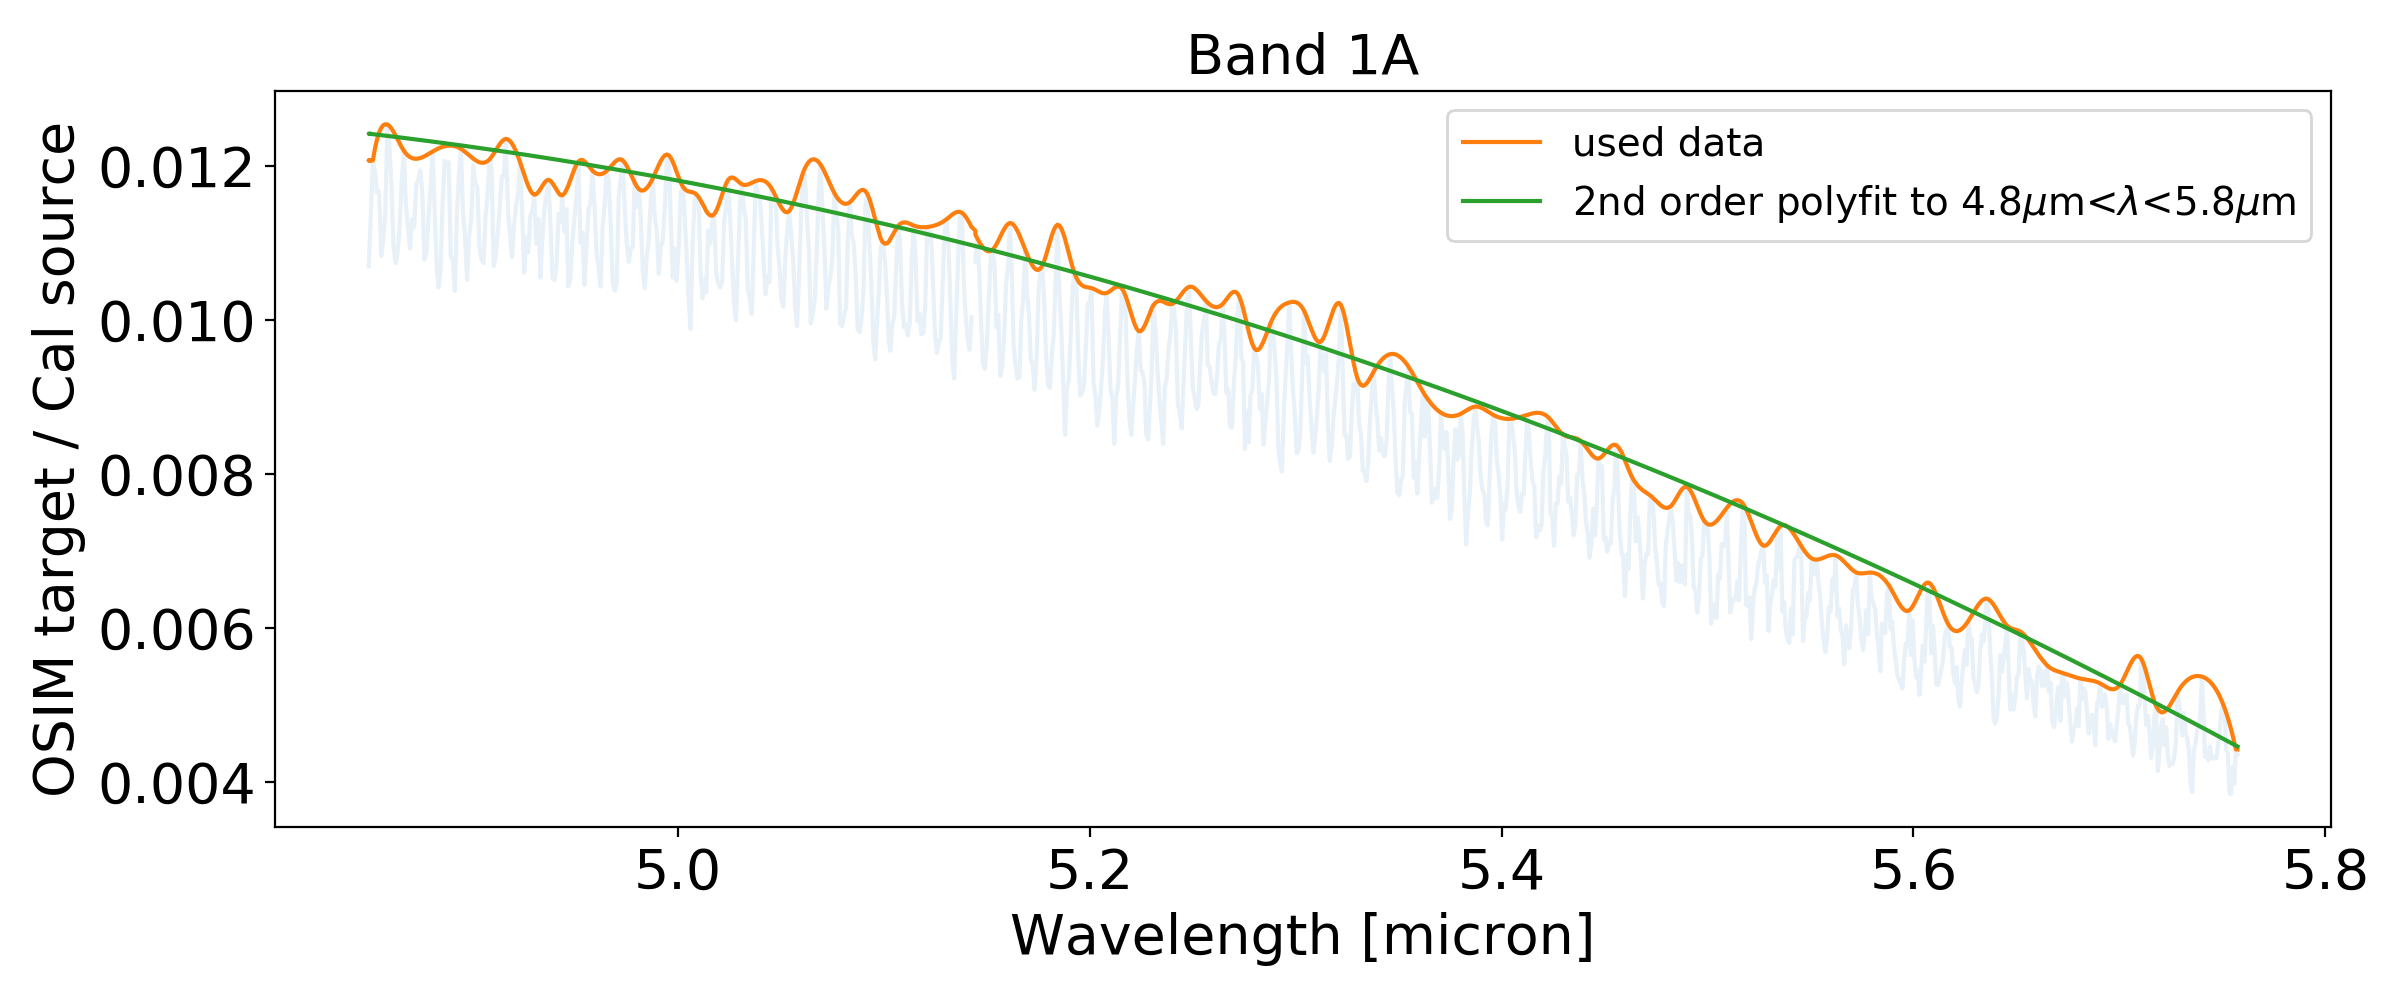

<IPython.core.display.Javascript object>


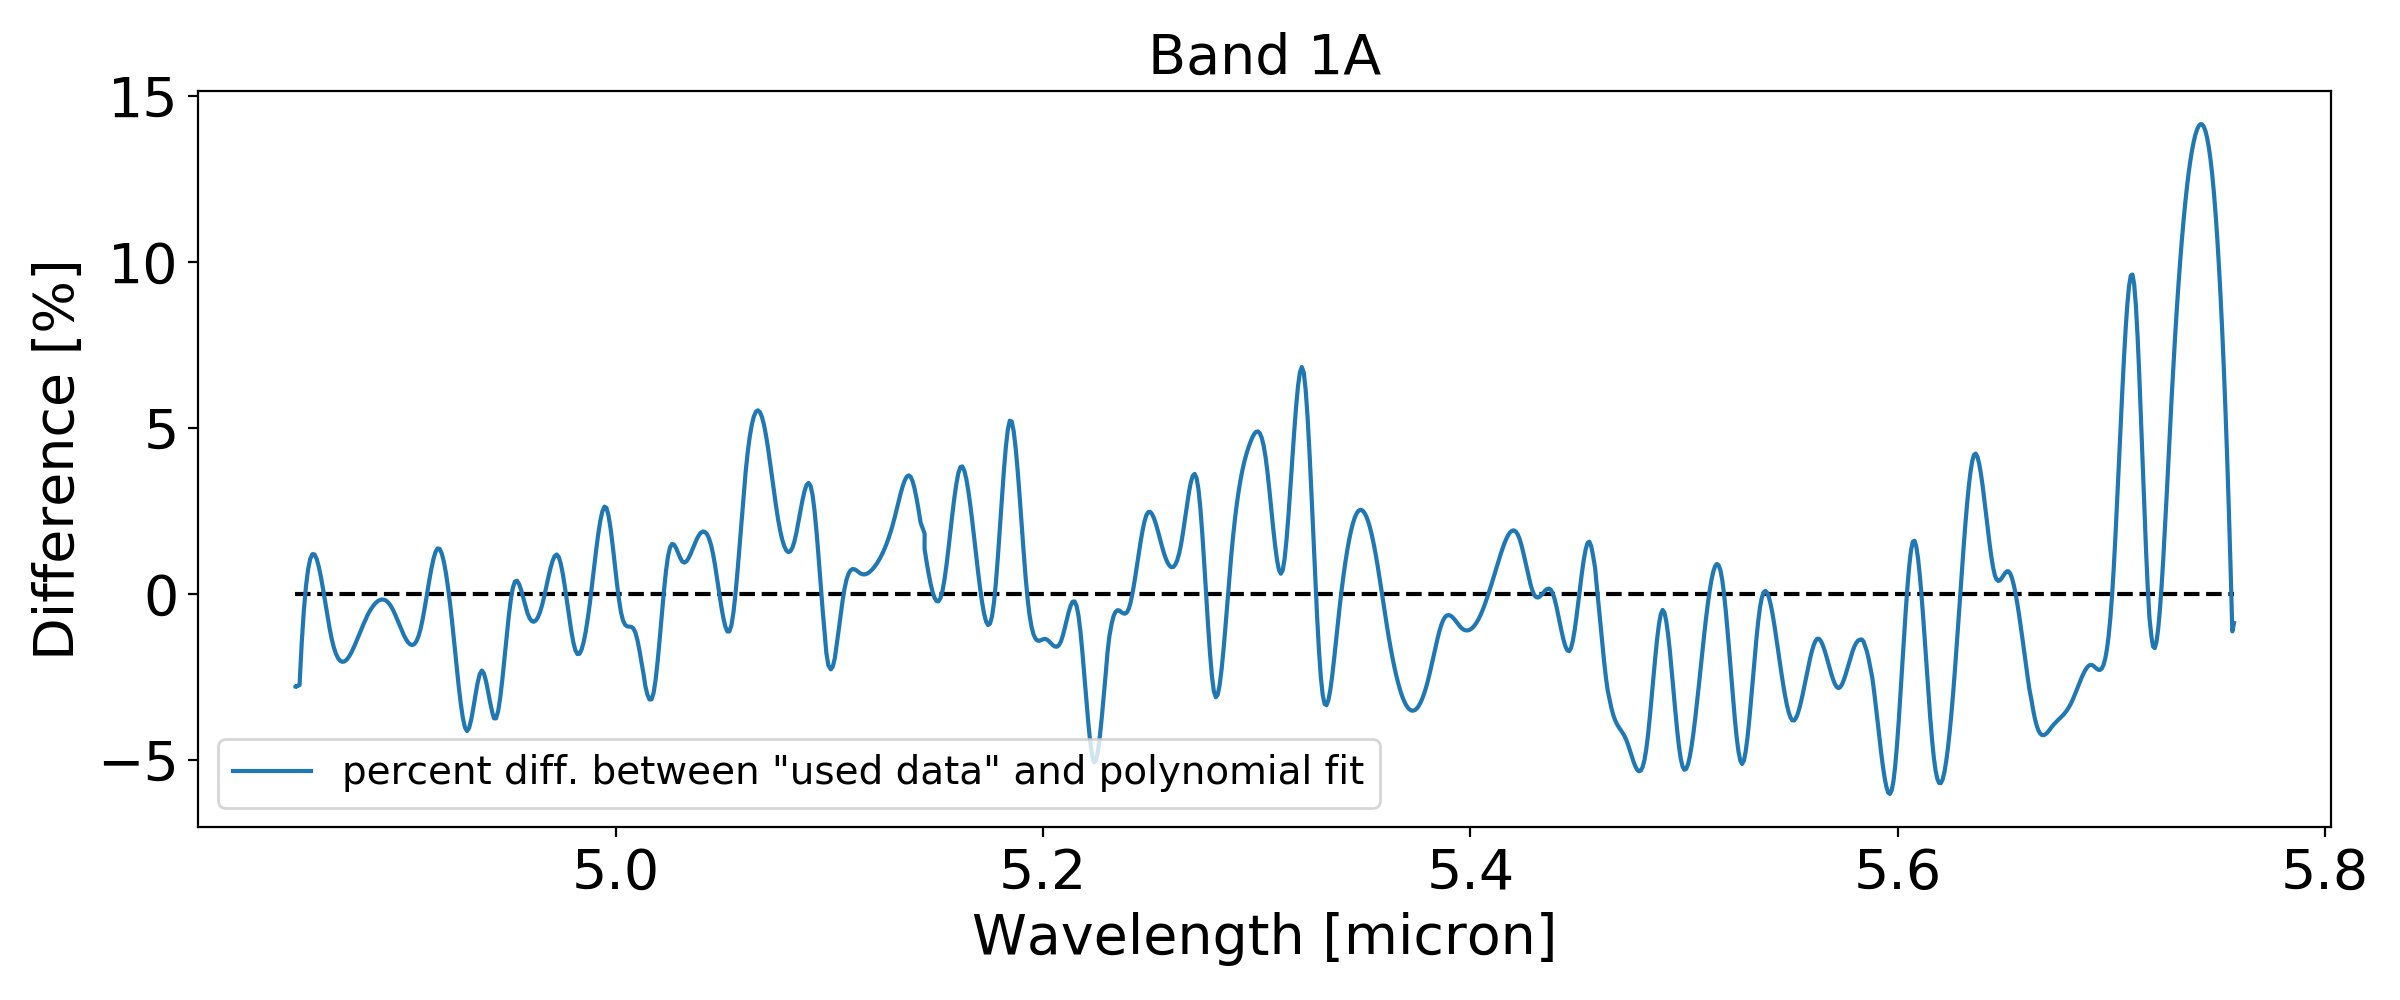

In [8]:
# Examine the OSIM sky flat data in band 1A (wavelength range 4.83-5.82 micron)
band = '1A'
lambdas = lambdaMap[band][ypos,xpos[band]][:-2]
data = ((img_SCI_1A-img_BKG_1A)/CV3_intcal_source_sci[band])[ypos,xpos[band]][:-2]
data_noNaN,peaks,data_profile = funcs.norm_fringe(data,thres=0,min_dist=6,k=3,ext=3)

# plot starter analysis
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,label='data')
plt.plot(lambdas[peaks],data_noNaN[peaks],'ro',markersize=2,label='fringe peaks')
plt.plot(lambdas,data_profile,label='fringe profile')
plt.xlabel('Wavelength [micron]')
plt.ylabel('OSIM target / Cal source')
plt.legend(loc='upper right')
plt.tight_layout()

# Investigate region of interest
popt1     = np.polyfit(lambdas,data_profile,2)
poly1     = np.poly1d(popt1)

# plot resulting fit and residuals
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,alpha=0.1)
plt.plot(lambdas,data_profile,label='used data')
plt.plot(lambdas,poly1(lambdas),label=r'2nd order polyfit to {}$\mu$m<$\lambda$<{}$\mu$m'.format(round(lambdas.min(),1),round(lambdas.max(),1) ))
plt.xlabel('Wavelength [micron]')
plt.ylabel('OSIM target / Cal source')
plt.legend(loc='upper right')
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,((data_profile-poly1(lambdas))/poly1(lambdas))*100.,label='percent diff. between "used data" and polynomial fit')
plt.hlines(0,lambdas.min(),lambdas.max(),linestyle='dashed')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Difference [%]')
plt.legend(loc='lower left')
plt.tight_layout()

<IPython.core.display.Javascript object>


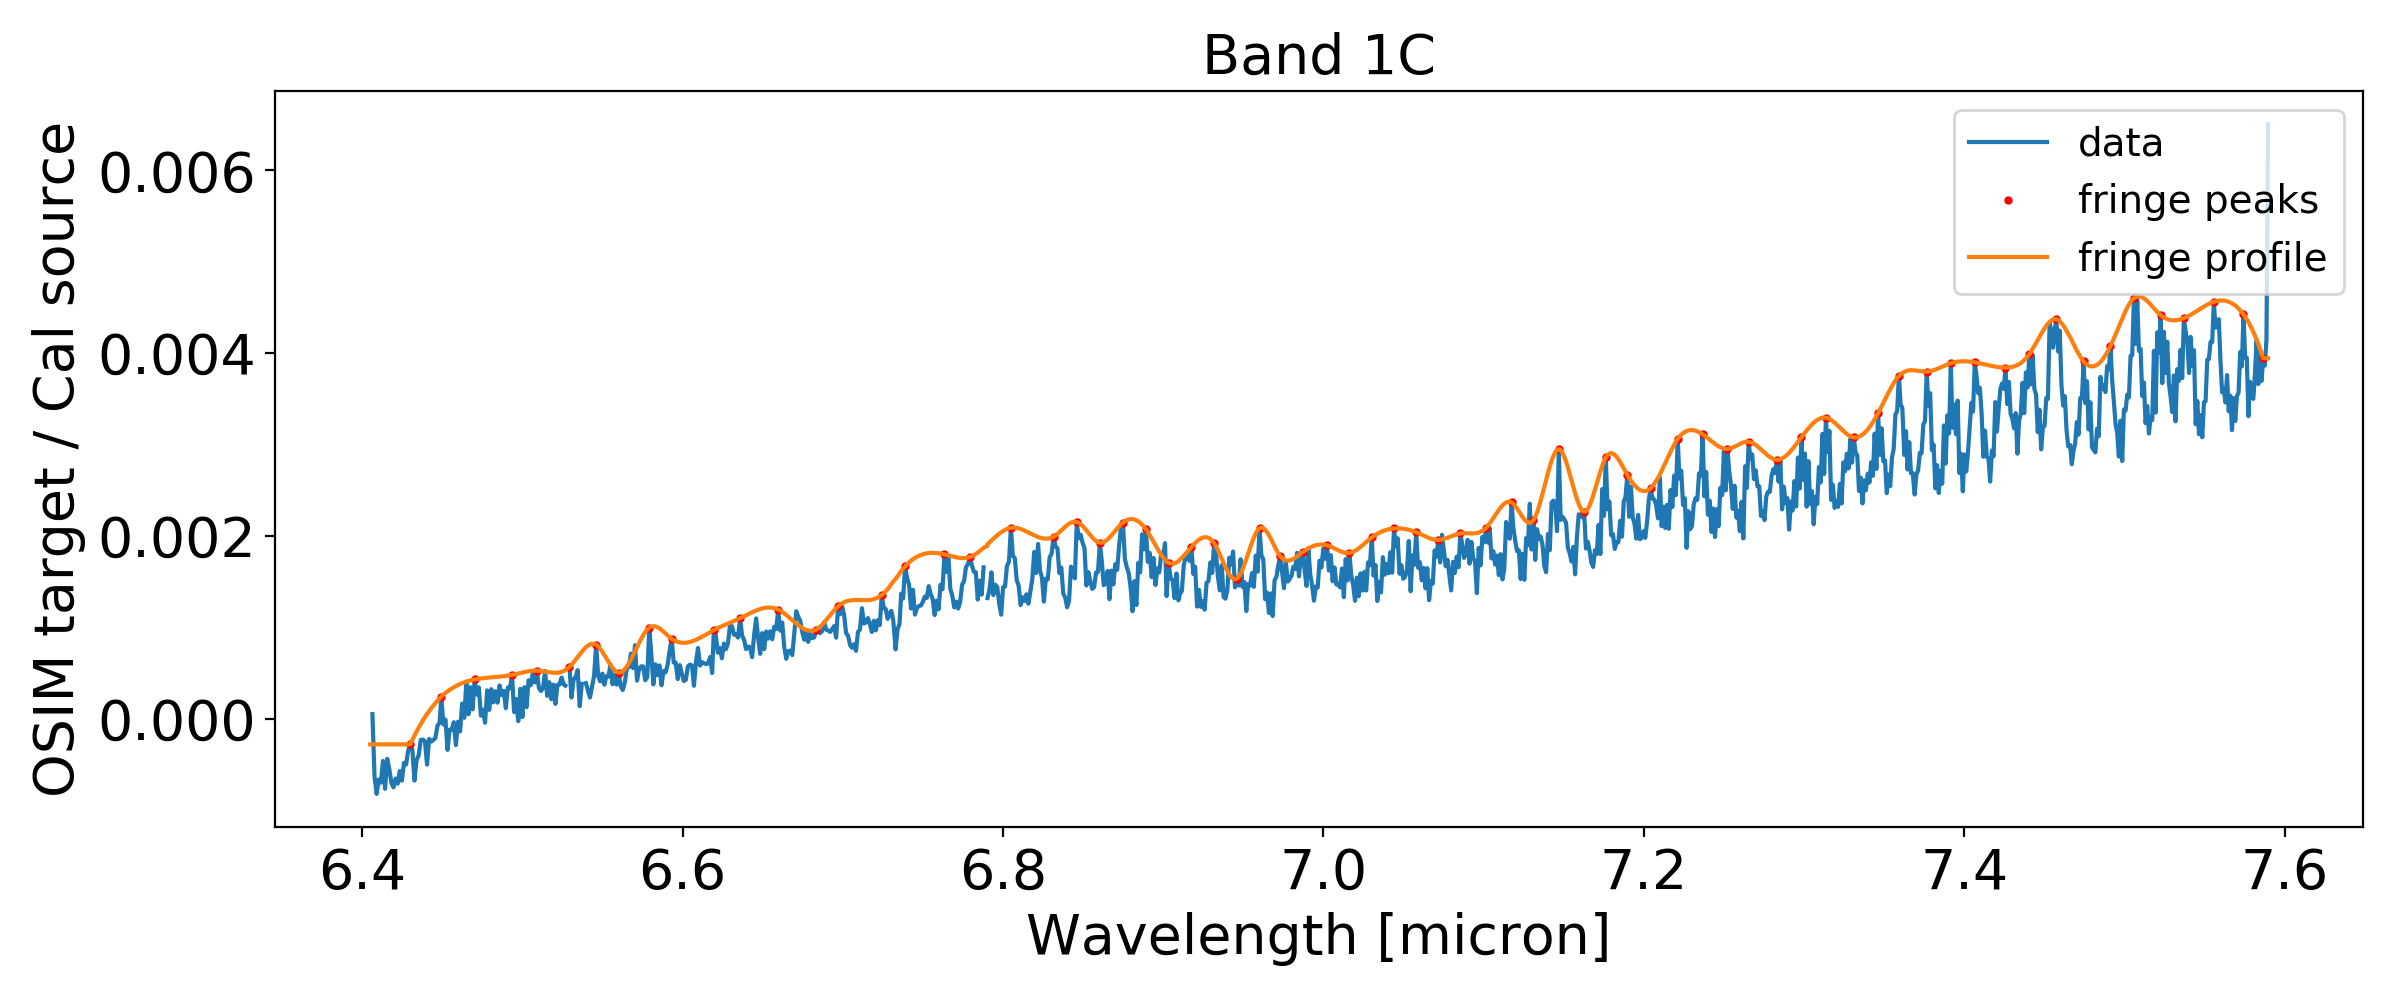

<IPython.core.display.Javascript object>


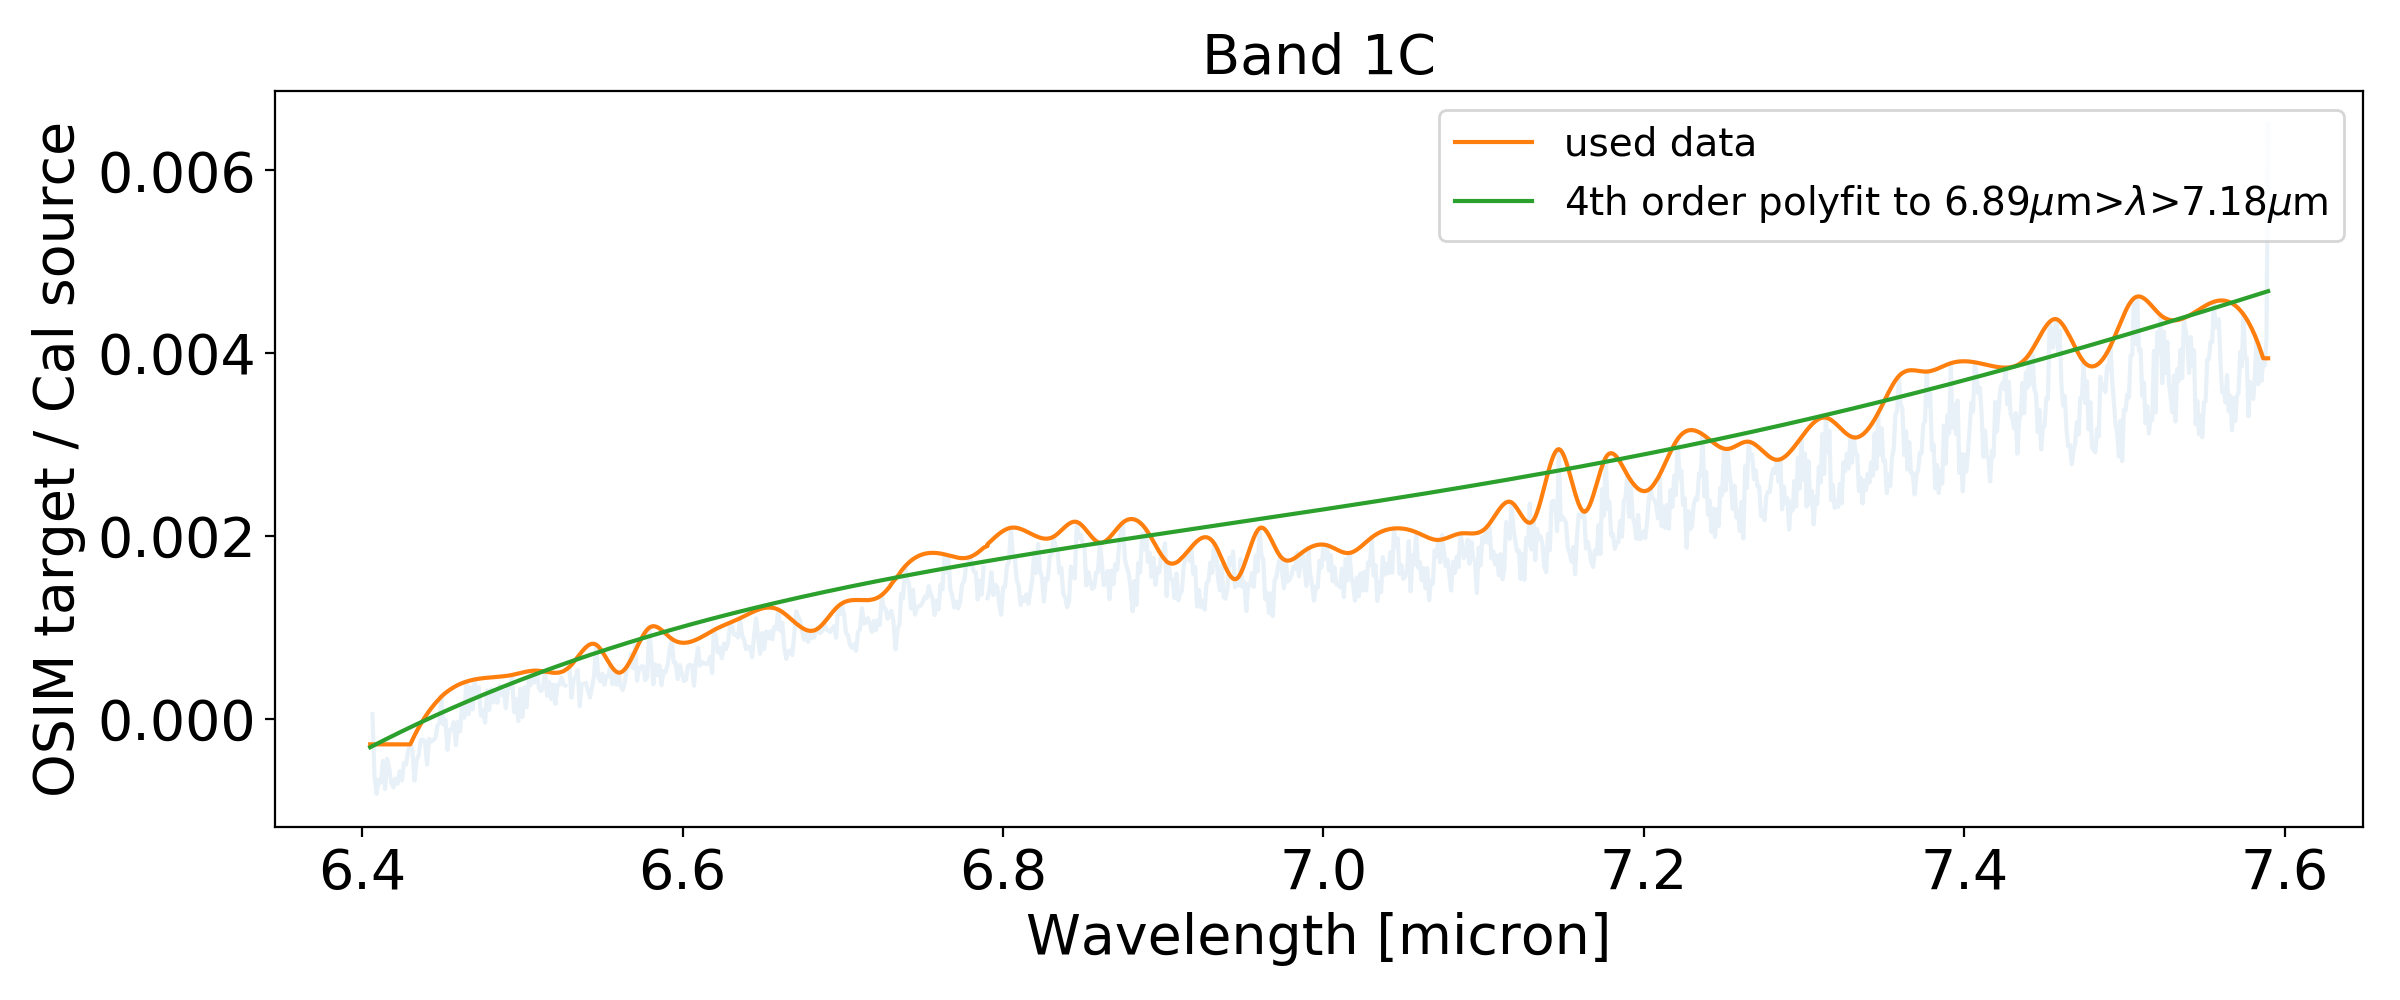

<IPython.core.display.Javascript object>


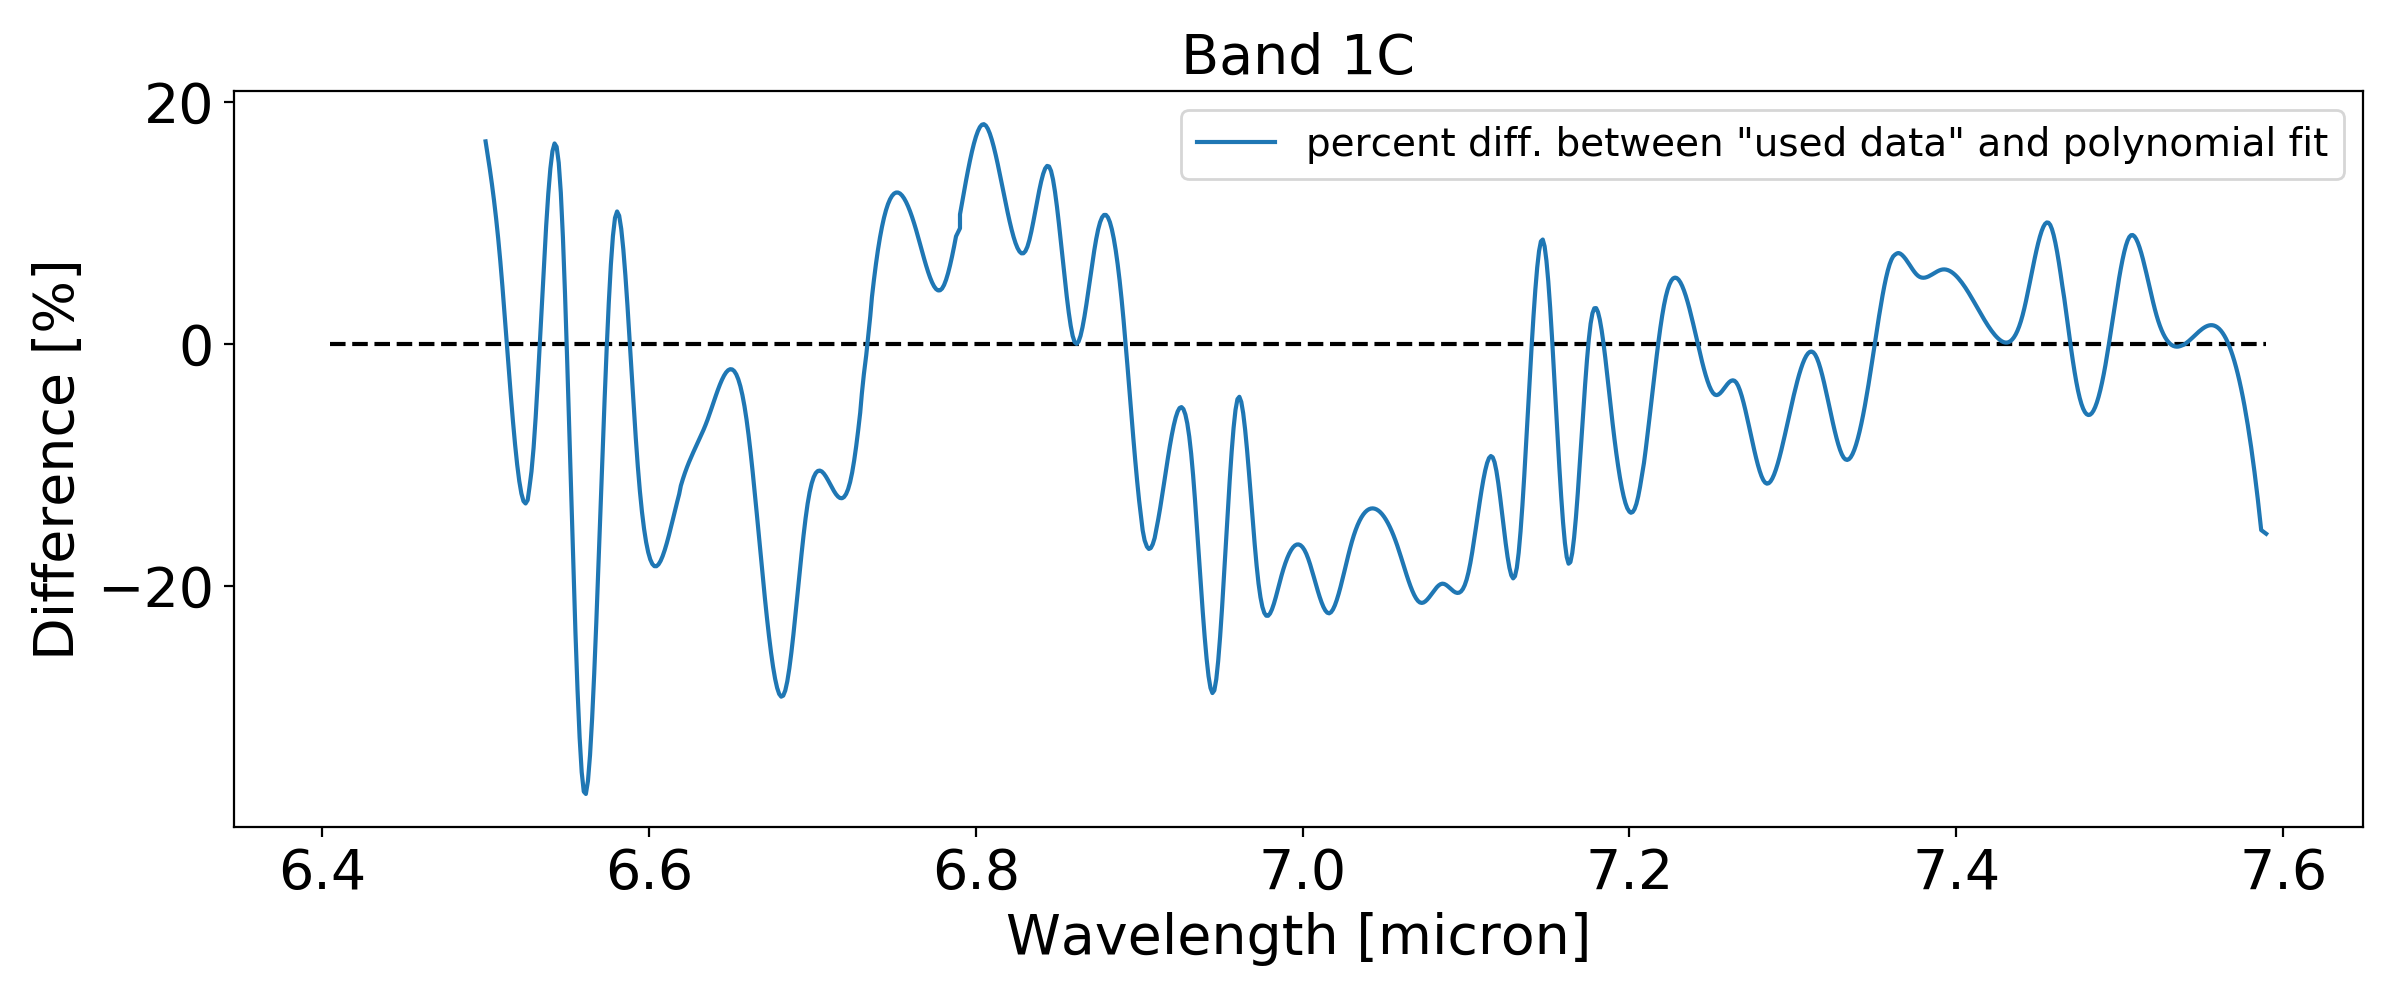

In [28]:
# Examine the OSIM sky flat data in band 1A (wavelength range 4.83-5.82 micron)
band = '1C'
lambdas = lambdaMap[band][ypos,xpos[band]][:-2]
data = (img_SCI_1C/CV3_intcal_source_sci[band])[ypos,xpos[band]][:-2]
data[np.where((lambdas<6.6)&(data>0.0012))] = np.nan
data_noNaN,peaks,data_profile = funcs.norm_fringe(data,thres=0,min_dist=10,k=3,ext=3)

# plot starter analysis
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,label='data')
plt.plot(lambdas[peaks],data_noNaN[peaks],'ro',markersize=2,label='fringe peaks')
plt.plot(lambdas,data_profile,label='fringe profile')
plt.xlabel('Wavelength [micron]')
plt.ylabel('OSIM target / Cal source')
plt.legend(loc='upper right')
plt.tight_layout()

# Investigate region of interest
sel = (lambdas>6.889) & (lambdas<7.18)
popt1     = np.polyfit(lambdas[~sel],data_profile[~sel],4)
poly1     = np.poly1d(popt1)

# plot resulting fit and residuals
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,alpha=0.1)
plt.plot(lambdas,data_profile,label='used data')
plt.plot(lambdas,poly1(lambdas),label=r'4th order polyfit to {}$\mu$m>$\lambda$>{}$\mu$m'.format(6.89,7.18 ))
plt.xlabel('Wavelength [micron]')
plt.ylabel('OSIM target / Cal source')
plt.legend(loc='upper right')
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas[lambdas>6.5],((data_profile-poly1(lambdas))/poly1(lambdas))[lambdas>6.5]*100.,label='percent diff. between "used data" and polynomial fit')
plt.hlines(0,lambdas.min(),lambdas.max(),linestyle='dashed')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Difference [%]')
plt.legend(loc='upper right')
plt.tight_layout()

<IPython.core.display.Javascript object>


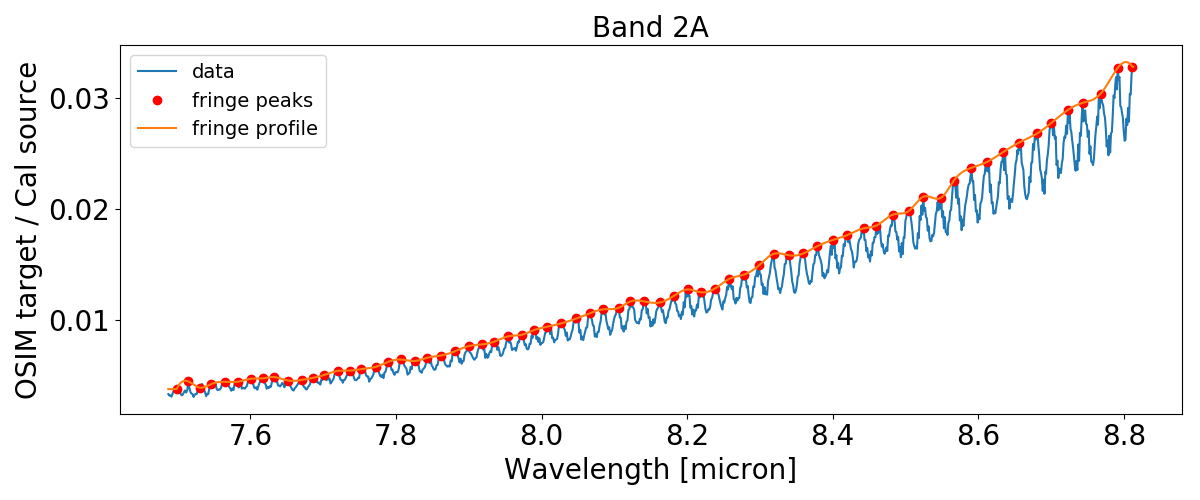

<IPython.core.display.Javascript object>


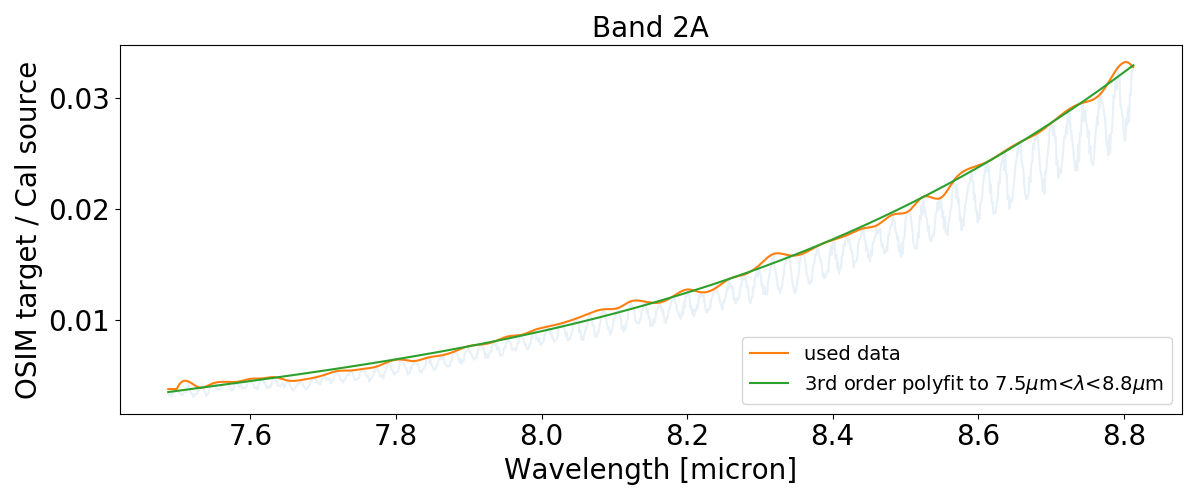

<IPython.core.display.Javascript object>


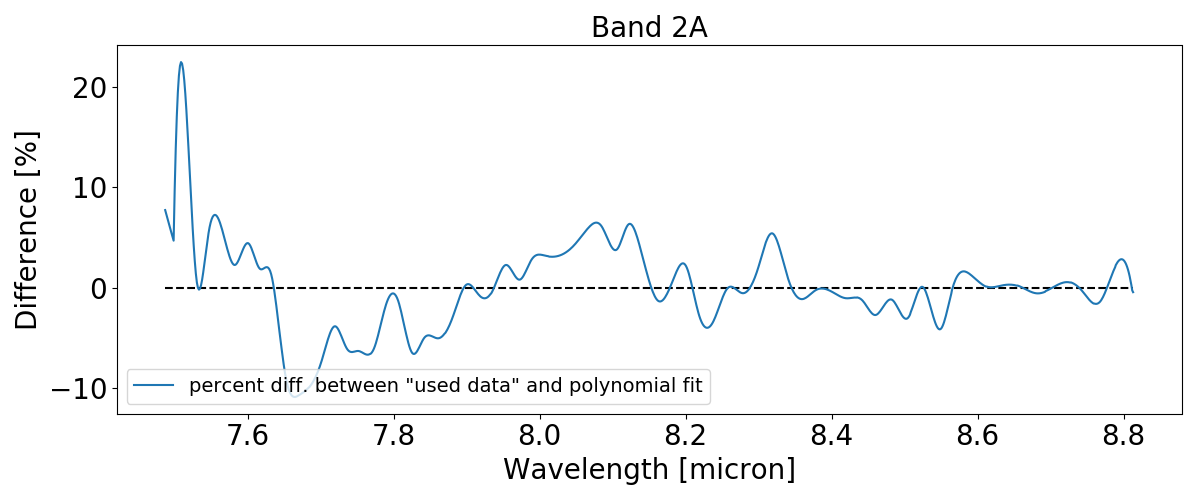

In [33]:
# Examine the OSIM sky flat data in band 2A (wavelength range 7.44-8.90 micron)
band = '2A'
lambdas = lambdaMap[band][ypos,xpos[band]][5:-3]
data = (img_SCI_1A/CV3_intcal_source_sci[band])[ypos,xpos[band]][5:-3]
data[np.where((lambdas<7.62)&(data>0.005))] = np.nan
data_noNaN,peaks,data_profile = funcs.norm_fringe(data,thres=0,min_dist=10,k=3,ext=3)

# plot starter analysis
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,label='data')
plt.plot(lambdas[peaks],data_noNaN[peaks],'ro',label='fringe peaks')
plt.plot(lambdas,data_profile,label='fringe profile')
plt.xlabel('Wavelength [micron]')
plt.ylabel('OSIM target / Cal source')
plt.legend(loc='upper left')
plt.tight_layout()

# # Investigate region of interest
popt1     = np.polyfit(lambdas,data_profile,3)
poly1     = np.poly1d(popt1)

# plot resulting fit and residuals
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,alpha=0.1)
plt.plot(lambdas,data_profile,label='used data')
plt.plot(lambdas,poly1(lambdas),label=r'3rd order polyfit to {}$\mu$m<$\lambda$<{}$\mu$m'.format(round(lambdas.min(),1),round(lambdas.max(),1)))
plt.xlabel('Wavelength [micron]')
plt.ylabel('OSIM target / Cal source')
plt.legend(loc='lower right')
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,((data_profile-poly1(lambdas))/poly1(lambdas))*100.,label='percent diff. between "used data" and polynomial fit')
plt.hlines(0,lambdas.min(),lambdas.max(),linestyle='dashed')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Difference [%]')
plt.legend(loc='lower left')
plt.tight_layout()

<IPython.core.display.Javascript object>


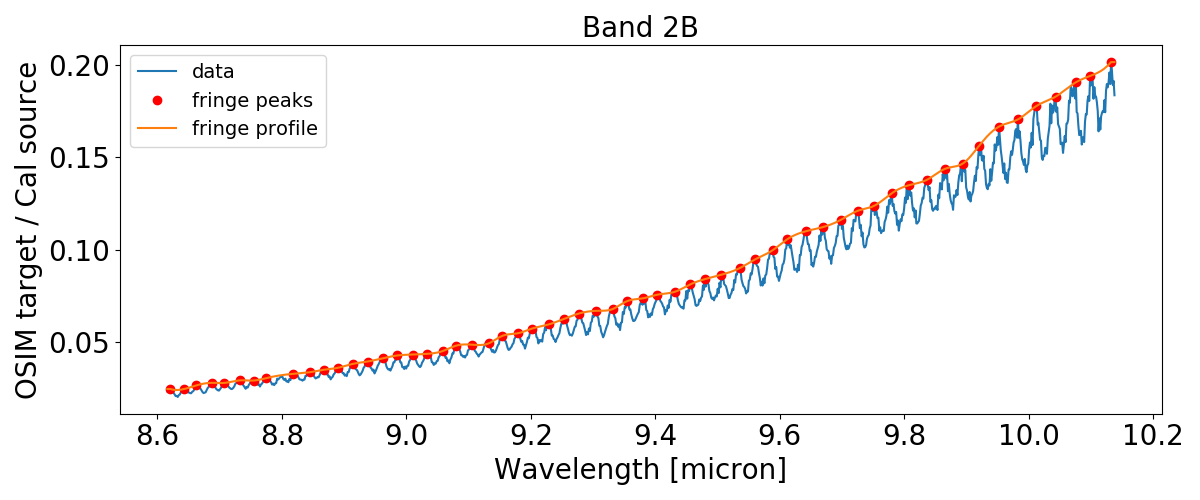

<IPython.core.display.Javascript object>


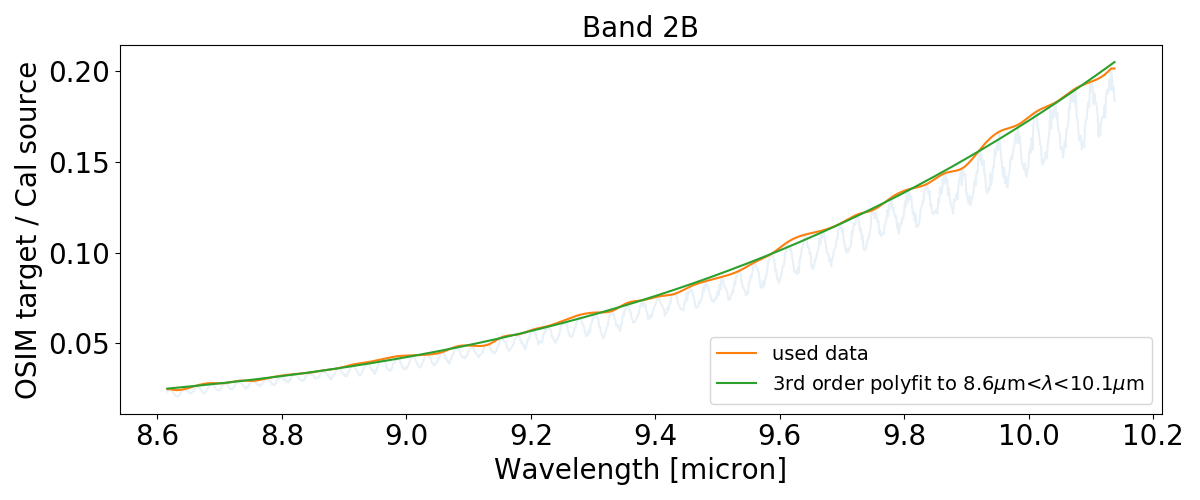

<IPython.core.display.Javascript object>


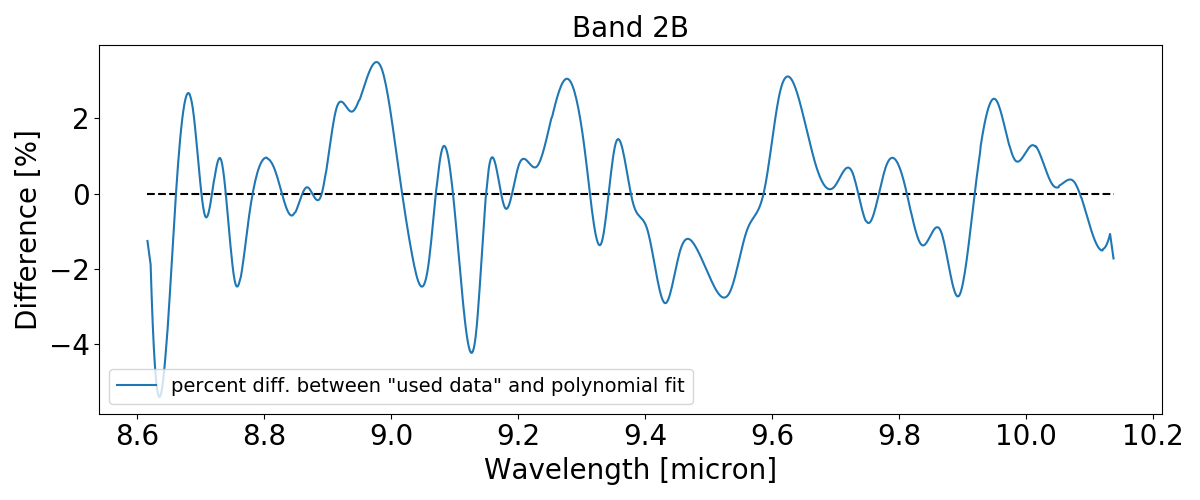

In [32]:
# Examine the OSIM sky flat data in band 2A (wavelength range 7.44-8.90 micron)
band = '2B'
lambdas = lambdaMap[band][ypos,xpos[band]][5:-3]
data = (img_SCI_1B/CV3_intcal_source_sci[band])[ypos,xpos[band]][5:-3]
data_noNaN,peaks,data_profile = funcs.norm_fringe(data,thres=0,min_dist=11,k=3,ext=3)

# plot starter analysis
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,label='data')
plt.plot(lambdas[peaks],data_noNaN[peaks],'ro',label='fringe peaks')
plt.plot(lambdas,data_profile,label='fringe profile')
plt.xlabel('Wavelength [micron]')
plt.ylabel('OSIM target / Cal source')
plt.legend(loc='upper left')
plt.tight_layout()

# Investigate region of interest
popt1     = np.polyfit(lambdas,data_profile,3)
poly1     = np.poly1d(popt1)

# plot resulting fit and residuals
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,alpha=0.1)
plt.plot(lambdas,data_profile,label='used data')
plt.plot(lambdas,poly1(lambdas),label=r'3rd order polyfit to {}$\mu$m<$\lambda$<{}$\mu$m'.format(round(lambdas.min(),1),round(lambdas.max(),1)))
plt.xlabel('Wavelength [micron]')
plt.ylabel('OSIM target / Cal source')
plt.legend(loc='lower right')
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,((data_profile-poly1(lambdas))/poly1(lambdas))*100.,label='percent diff. between "used data" and polynomial fit')
plt.hlines(0,lambdas.min(),lambdas.max(),linestyle='dashed')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Difference [%]')
plt.legend(loc='lower left')
plt.tight_layout()